In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 60))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

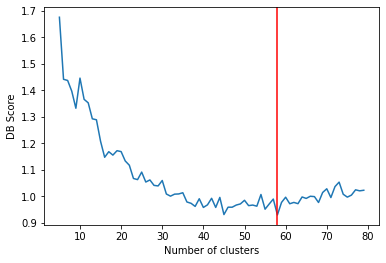

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

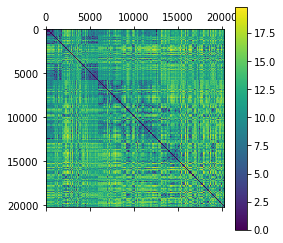

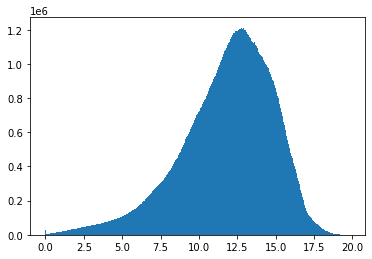

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

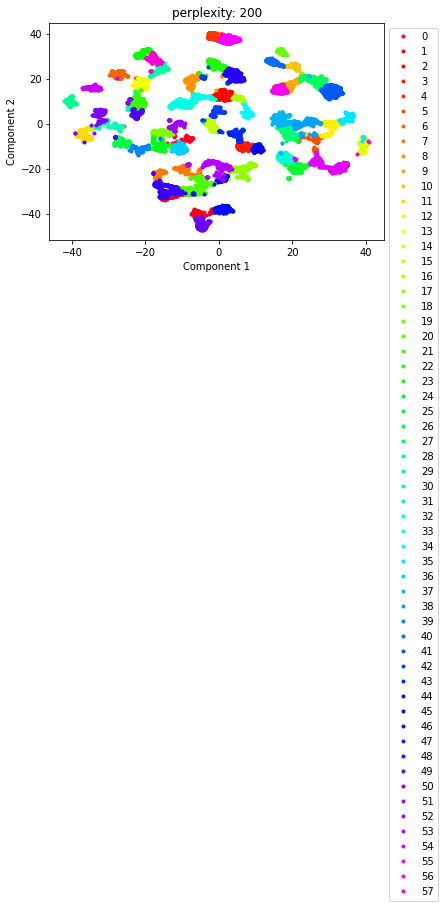

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9603804267481397


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.30161533351695535
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.8344267955801106
layer 6: 0.6799033149171272
layer 7: 0.47902279005524867
layer 8: 0.26268991712707185
Epoch: 00 | Batch: 000 / 011 | Total loss: 4.069 | Reg loss: 0.019 | Tree loss: 4.069 | Accuracy: 0.048500 | 1.057 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 4.066 | Reg loss: 0.019 | Tree loss: 4.066 | Accuracy: 0.029000 | 0.994 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 4.061 | Reg loss: 0.018 | Tree loss: 4.061 | Accuracy: 0.048500 | 0.975 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 4.057 | Reg loss: 0.018 | Tree loss: 4.057 | Accuracy: 0.054500 | 0.967 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 4.055 | Reg loss: 0.018 | Tree loss: 4.055 | Accuracy: 0.048000 | 0.963 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 4.051 | Reg loss: 0.018 | Tree loss: 4.051 | Acc

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 4.043 | Reg loss: 0.015 | Tree loss: 4.043 | Accuracy: 0.097500 | 0.956 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 4.035 | Reg loss: 0.015 | Tree loss: 4.035 | Accuracy: 0.087000 | 0.955 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 4.020 | Reg loss: 0.015 | Tree loss: 4.020 | Accuracy: 0.117000 | 0.955 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 4.005 | Reg loss: 0.016 | Tree loss: 4.005 | Accuracy: 0.105000 | 0.955 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 3.985 | Reg loss: 0.016 | Tree loss: 3.985 | Accuracy: 0.102500 | 0.955 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 3.968 | Reg loss: 0.016 | Tree loss: 3.968 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 3.950 | Reg loss: 0.018 | Tree loss: 3.950 | Accuracy: 0.160500 | 0.955 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 3.921 | Reg loss: 0.018 | Tree loss: 3.921 | Accuracy: 0.153500 | 0.955 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 3.879 | Reg loss: 0.018 | Tree loss: 3.879 | Accuracy: 0.158500 | 0.955 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 3.842 | Reg loss: 0.018 | Tree loss: 3.842 | Accuracy: 0.144500 | 0.955 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 3.793 | Reg loss: 0.018 | Tree loss: 3.793 | Accuracy: 0.135500 | 0.955 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 3.763 | Reg loss: 0.019 | Tree loss: 3.763 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 3.735 | Reg loss: 0.021 | Tree loss: 3.735 | Accuracy: 0.179500 | 0.955 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 3.676 | Reg loss: 0.021 | Tree loss: 3.676 | Accuracy: 0.169000 | 0.955 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 3.632 | Reg loss: 0.021 | Tree loss: 3.632 | Accuracy: 0.162000 | 0.955 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 3.585 | Reg loss: 0.021 | Tree loss: 3.585 | Accuracy: 0.159000 | 0.954 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 3.539 | Reg loss: 0.021 | Tree loss: 3.539 | Accuracy: 0.164500 | 0.954 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 3.495 | Reg loss: 0.022 | Tree loss: 3.495 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 3.481 | Reg loss: 0.024 | Tree loss: 3.481 | Accuracy: 0.213000 | 0.955 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 3.433 | Reg loss: 0.024 | Tree loss: 3.433 | Accuracy: 0.203000 | 0.955 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 3.387 | Reg loss: 0.024 | Tree loss: 3.387 | Accuracy: 0.198500 | 0.954 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 3.329 | Reg loss: 0.024 | Tree loss: 3.329 | Accuracy: 0.202000 | 0.954 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 3.287 | Reg loss: 0.024 | Tree loss: 3.287 | Accuracy: 0.192500 | 0.954 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 3.241 | Reg loss: 0.024 | Tree loss: 3.241 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 3.295 | Reg loss: 0.026 | Tree loss: 3.295 | Accuracy: 0.204500 | 0.955 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 3.254 | Reg loss: 0.026 | Tree loss: 3.254 | Accuracy: 0.194000 | 0.954 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 3.228 | Reg loss: 0.026 | Tree loss: 3.228 | Accuracy: 0.215000 | 0.954 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 3.180 | Reg loss: 0.026 | Tree loss: 3.180 | Accuracy: 0.204500 | 0.954 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 3.117 | Reg loss: 0.026 | Tree loss: 3.117 | Accuracy: 0.232500 | 0.954 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 3.094 | Reg loss: 0.026 | Tree loss: 3.094 | A

Epoch: 30 | Batch: 000 / 011 | Total loss: 3.172 | Reg loss: 0.028 | Tree loss: 3.172 | Accuracy: 0.207000 | 0.944 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 3.147 | Reg loss: 0.028 | Tree loss: 3.147 | Accuracy: 0.212000 | 0.943 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 3.090 | Reg loss: 0.028 | Tree loss: 3.090 | Accuracy: 0.220000 | 0.943 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 3.070 | Reg loss: 0.028 | Tree loss: 3.070 | Accuracy: 0.208500 | 0.943 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 3.021 | Reg loss: 0.028 | Tree loss: 3.021 | Accuracy: 0.222500 | 0.943 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 3.006 | Reg loss: 0.028 | Tree loss: 3.006 | Accuracy: 0.218500 | 0.942 sec/iter
Epoch: 30 | Batch: 006 / 011 | Total loss: 2.964 | Reg loss: 0.028 | Tree loss: 2.964 | Accuracy: 0.217500 | 0.942 sec/iter
Epoch: 30 | Batch: 007 / 011 | Total loss: 2.959 | Reg loss: 0.028 | Tree loss: 2.959 | Accuracy: 0.178500 | 0.942 sec/iter
Epoch: 3

Epoch: 35 | Batch: 000 / 011 | Total loss: 3.104 | Reg loss: 0.029 | Tree loss: 3.104 | Accuracy: 0.214000 | 0.933 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 3.077 | Reg loss: 0.029 | Tree loss: 3.077 | Accuracy: 0.187000 | 0.933 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 3.018 | Reg loss: 0.029 | Tree loss: 3.018 | Accuracy: 0.220500 | 0.933 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 2.981 | Reg loss: 0.029 | Tree loss: 2.981 | Accuracy: 0.207000 | 0.932 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 2.940 | Reg loss: 0.029 | Tree loss: 2.940 | Accuracy: 0.237500 | 0.932 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 2.919 | Reg loss: 0.029 | Tree loss: 2.919 | Accuracy: 0.206000 | 0.932 sec/iter
Epoch: 35 | Batch: 006 / 011 | Total loss: 2.908 | Reg loss: 0.029 | Tree loss: 2.908 | Accuracy: 0.227000 | 0.932 sec/iter
Epoch: 35 | Batch: 007 / 011 | Total loss: 2.885 | Reg loss: 0.029 | Tree loss: 2.885 | Accuracy: 0.239500 | 0.932 sec/iter
Epoch: 3

Epoch: 40 | Batch: 000 / 011 | Total loss: 3.041 | Reg loss: 0.029 | Tree loss: 3.041 | Accuracy: 0.190500 | 0.924 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 3.002 | Reg loss: 0.029 | Tree loss: 3.002 | Accuracy: 0.202000 | 0.923 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 2.960 | Reg loss: 0.029 | Tree loss: 2.960 | Accuracy: 0.217000 | 0.923 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 2.925 | Reg loss: 0.029 | Tree loss: 2.925 | Accuracy: 0.219000 | 0.923 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 2.876 | Reg loss: 0.029 | Tree loss: 2.876 | Accuracy: 0.249500 | 0.923 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 2.847 | Reg loss: 0.029 | Tree loss: 2.847 | Accuracy: 0.252500 | 0.923 sec/iter
Epoch: 40 | Batch: 006 / 011 | Total loss: 2.835 | Reg loss: 0.029 | Tree loss: 2.835 | Accuracy: 0.244500 | 0.923 sec/iter
Epoch: 40 | Batch: 007 / 011 | Total loss: 2.804 | Reg loss: 0.030 | Tree loss: 2.804 | Accuracy: 0.214000 | 0.922 sec/iter
Epoch: 4

Epoch: 45 | Batch: 000 / 011 | Total loss: 3.005 | Reg loss: 0.030 | Tree loss: 3.005 | Accuracy: 0.203000 | 0.916 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 2.941 | Reg loss: 0.030 | Tree loss: 2.941 | Accuracy: 0.207000 | 0.915 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 2.912 | Reg loss: 0.030 | Tree loss: 2.912 | Accuracy: 0.216500 | 0.915 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 2.875 | Reg loss: 0.030 | Tree loss: 2.875 | Accuracy: 0.241000 | 0.915 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 2.855 | Reg loss: 0.030 | Tree loss: 2.855 | Accuracy: 0.229000 | 0.915 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 2.816 | Reg loss: 0.030 | Tree loss: 2.816 | Accuracy: 0.252000 | 0.915 sec/iter
Epoch: 45 | Batch: 006 / 011 | Total loss: 2.775 | Reg loss: 0.030 | Tree loss: 2.775 | Accuracy: 0.265000 | 0.915 sec/iter
Epoch: 45 | Batch: 007 / 011 | Total loss: 2.766 | Reg loss: 0.030 | Tree loss: 2.766 | Accuracy: 0.235500 | 0.915 sec/iter
Epoch: 4

Epoch: 50 | Batch: 000 / 011 | Total loss: 2.963 | Reg loss: 0.030 | Tree loss: 2.963 | Accuracy: 0.212000 | 0.909 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 2.924 | Reg loss: 0.030 | Tree loss: 2.924 | Accuracy: 0.213000 | 0.909 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 2.870 | Reg loss: 0.030 | Tree loss: 2.870 | Accuracy: 0.227000 | 0.909 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 2.839 | Reg loss: 0.031 | Tree loss: 2.839 | Accuracy: 0.232500 | 0.909 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 2.796 | Reg loss: 0.031 | Tree loss: 2.796 | Accuracy: 0.246000 | 0.909 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 2.767 | Reg loss: 0.031 | Tree loss: 2.767 | Accuracy: 0.272500 | 0.909 sec/iter
Epoch: 50 | Batch: 006 / 011 | Total loss: 2.746 | Reg loss: 0.031 | Tree loss: 2.746 | Accuracy: 0.248500 | 0.909 sec/iter
Epoch: 50 | Batch: 007 / 011 | Total loss: 2.713 | Reg loss: 0.031 | Tree loss: 2.713 | Accuracy: 0.248000 | 0.908 sec/iter
Epoch: 5

Epoch: 55 | Batch: 000 / 011 | Total loss: 2.932 | Reg loss: 0.031 | Tree loss: 2.932 | Accuracy: 0.209000 | 0.904 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 2.875 | Reg loss: 0.031 | Tree loss: 2.875 | Accuracy: 0.237500 | 0.904 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 2.834 | Reg loss: 0.031 | Tree loss: 2.834 | Accuracy: 0.240500 | 0.904 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 2.804 | Reg loss: 0.031 | Tree loss: 2.804 | Accuracy: 0.252000 | 0.904 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 2.773 | Reg loss: 0.031 | Tree loss: 2.773 | Accuracy: 0.244500 | 0.904 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 2.753 | Reg loss: 0.031 | Tree loss: 2.753 | Accuracy: 0.245000 | 0.903 sec/iter
Epoch: 55 | Batch: 006 / 011 | Total loss: 2.704 | Reg loss: 0.031 | Tree loss: 2.704 | Accuracy: 0.257000 | 0.903 sec/iter
Epoch: 55 | Batch: 007 / 011 | Total loss: 2.677 | Reg loss: 0.031 | Tree loss: 2.677 | Accuracy: 0.244000 | 0.903 sec/iter
Epoch: 5

Epoch: 60 | Batch: 000 / 011 | Total loss: 2.898 | Reg loss: 0.031 | Tree loss: 2.898 | Accuracy: 0.224500 | 0.899 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 2.875 | Reg loss: 0.031 | Tree loss: 2.875 | Accuracy: 0.216500 | 0.899 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 2.812 | Reg loss: 0.031 | Tree loss: 2.812 | Accuracy: 0.234500 | 0.899 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 2.772 | Reg loss: 0.031 | Tree loss: 2.772 | Accuracy: 0.236500 | 0.899 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 2.700 | Reg loss: 0.031 | Tree loss: 2.700 | Accuracy: 0.253500 | 0.899 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 2.695 | Reg loss: 0.032 | Tree loss: 2.695 | Accuracy: 0.263000 | 0.899 sec/iter
Epoch: 60 | Batch: 006 / 011 | Total loss: 2.673 | Reg loss: 0.032 | Tree loss: 2.673 | Accuracy: 0.267500 | 0.899 sec/iter
Epoch: 60 | Batch: 007 / 011 | Total loss: 2.651 | Reg loss: 0.032 | Tree loss: 2.651 | Accuracy: 0.271000 | 0.899 sec/iter
Epoch: 6

Epoch: 65 | Batch: 000 / 011 | Total loss: 2.860 | Reg loss: 0.032 | Tree loss: 2.860 | Accuracy: 0.212500 | 0.895 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 2.795 | Reg loss: 0.032 | Tree loss: 2.795 | Accuracy: 0.235000 | 0.895 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 2.784 | Reg loss: 0.032 | Tree loss: 2.784 | Accuracy: 0.249500 | 0.895 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 2.754 | Reg loss: 0.032 | Tree loss: 2.754 | Accuracy: 0.243500 | 0.895 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 2.721 | Reg loss: 0.032 | Tree loss: 2.721 | Accuracy: 0.243500 | 0.895 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 2.645 | Reg loss: 0.032 | Tree loss: 2.645 | Accuracy: 0.275000 | 0.895 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 2.648 | Reg loss: 0.032 | Tree loss: 2.648 | Accuracy: 0.292500 | 0.895 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 2.616 | Reg loss: 0.032 | Tree loss: 2.616 | Accuracy: 0.285000 | 0.895 sec/iter
Epoch: 6

Epoch: 70 | Batch: 000 / 011 | Total loss: 2.815 | Reg loss: 0.032 | Tree loss: 2.815 | Accuracy: 0.224000 | 0.892 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 2.797 | Reg loss: 0.032 | Tree loss: 2.797 | Accuracy: 0.213500 | 0.892 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 2.771 | Reg loss: 0.032 | Tree loss: 2.771 | Accuracy: 0.242500 | 0.892 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 2.705 | Reg loss: 0.032 | Tree loss: 2.705 | Accuracy: 0.246000 | 0.892 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 2.671 | Reg loss: 0.032 | Tree loss: 2.671 | Accuracy: 0.263500 | 0.892 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 2.640 | Reg loss: 0.032 | Tree loss: 2.640 | Accuracy: 0.262500 | 0.892 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 2.633 | Reg loss: 0.032 | Tree loss: 2.633 | Accuracy: 0.279000 | 0.892 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 2.585 | Reg loss: 0.033 | Tree loss: 2.585 | Accuracy: 0.291500 | 0.892 sec/iter
Epoch: 7

Epoch: 75 | Batch: 000 / 011 | Total loss: 2.813 | Reg loss: 0.033 | Tree loss: 2.813 | Accuracy: 0.231000 | 0.889 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 2.782 | Reg loss: 0.033 | Tree loss: 2.782 | Accuracy: 0.233000 | 0.889 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 2.750 | Reg loss: 0.033 | Tree loss: 2.750 | Accuracy: 0.243000 | 0.889 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 2.675 | Reg loss: 0.033 | Tree loss: 2.675 | Accuracy: 0.264500 | 0.889 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 2.626 | Reg loss: 0.033 | Tree loss: 2.626 | Accuracy: 0.270500 | 0.889 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 2.610 | Reg loss: 0.033 | Tree loss: 2.610 | Accuracy: 0.274000 | 0.889 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 2.597 | Reg loss: 0.033 | Tree loss: 2.597 | Accuracy: 0.278500 | 0.889 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 2.574 | Reg loss: 0.033 | Tree loss: 2.574 | Accuracy: 0.277000 | 0.889 sec/iter
Epoch: 7

Epoch: 80 | Batch: 000 / 011 | Total loss: 2.793 | Reg loss: 0.033 | Tree loss: 2.793 | Accuracy: 0.212000 | 0.887 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 2.763 | Reg loss: 0.033 | Tree loss: 2.763 | Accuracy: 0.241000 | 0.887 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 2.722 | Reg loss: 0.033 | Tree loss: 2.722 | Accuracy: 0.259000 | 0.887 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 2.647 | Reg loss: 0.033 | Tree loss: 2.647 | Accuracy: 0.281000 | 0.887 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 2.628 | Reg loss: 0.033 | Tree loss: 2.628 | Accuracy: 0.277500 | 0.887 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 2.592 | Reg loss: 0.033 | Tree loss: 2.592 | Accuracy: 0.292500 | 0.886 sec/iter
Epoch: 80 | Batch: 006 / 011 | Total loss: 2.576 | Reg loss: 0.033 | Tree loss: 2.576 | Accuracy: 0.294000 | 0.886 sec/iter
Epoch: 80 | Batch: 007 / 011 | Total loss: 2.561 | Reg loss: 0.033 | Tree loss: 2.561 | Accuracy: 0.273500 | 0.886 sec/iter
Epoch: 8

Epoch: 85 | Batch: 000 / 011 | Total loss: 2.781 | Reg loss: 0.034 | Tree loss: 2.781 | Accuracy: 0.253000 | 0.885 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 2.739 | Reg loss: 0.034 | Tree loss: 2.739 | Accuracy: 0.241500 | 0.884 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 2.689 | Reg loss: 0.034 | Tree loss: 2.689 | Accuracy: 0.269500 | 0.884 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 2.631 | Reg loss: 0.034 | Tree loss: 2.631 | Accuracy: 0.291500 | 0.884 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 2.611 | Reg loss: 0.034 | Tree loss: 2.611 | Accuracy: 0.261000 | 0.884 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 2.586 | Reg loss: 0.034 | Tree loss: 2.586 | Accuracy: 0.256000 | 0.884 sec/iter
Epoch: 85 | Batch: 006 / 011 | Total loss: 2.559 | Reg loss: 0.034 | Tree loss: 2.559 | Accuracy: 0.278500 | 0.884 sec/iter
Epoch: 85 | Batch: 007 / 011 | Total loss: 2.536 | Reg loss: 0.034 | Tree loss: 2.536 | Accuracy: 0.279000 | 0.884 sec/iter
Epoch: 8

Epoch: 90 | Batch: 000 / 011 | Total loss: 2.765 | Reg loss: 0.034 | Tree loss: 2.765 | Accuracy: 0.245500 | 0.882 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 2.716 | Reg loss: 0.034 | Tree loss: 2.716 | Accuracy: 0.250500 | 0.882 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 2.671 | Reg loss: 0.034 | Tree loss: 2.671 | Accuracy: 0.275000 | 0.882 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 2.608 | Reg loss: 0.034 | Tree loss: 2.608 | Accuracy: 0.300000 | 0.882 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 2.598 | Reg loss: 0.034 | Tree loss: 2.598 | Accuracy: 0.275500 | 0.882 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 2.568 | Reg loss: 0.034 | Tree loss: 2.568 | Accuracy: 0.272500 | 0.882 sec/iter
Epoch: 90 | Batch: 006 / 011 | Total loss: 2.553 | Reg loss: 0.034 | Tree loss: 2.553 | Accuracy: 0.280500 | 0.882 sec/iter
Epoch: 90 | Batch: 007 / 011 | Total loss: 2.520 | Reg loss: 0.034 | Tree loss: 2.520 | Accuracy: 0.270000 | 0.882 sec/iter
Epoch: 9

Epoch: 95 | Batch: 000 / 011 | Total loss: 2.742 | Reg loss: 0.034 | Tree loss: 2.742 | Accuracy: 0.257500 | 0.881 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 2.680 | Reg loss: 0.034 | Tree loss: 2.680 | Accuracy: 0.264000 | 0.88 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 2.649 | Reg loss: 0.034 | Tree loss: 2.649 | Accuracy: 0.274000 | 0.88 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 2.621 | Reg loss: 0.034 | Tree loss: 2.621 | Accuracy: 0.269500 | 0.88 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 2.567 | Reg loss: 0.034 | Tree loss: 2.567 | Accuracy: 0.283500 | 0.88 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 2.531 | Reg loss: 0.034 | Tree loss: 2.531 | Accuracy: 0.289500 | 0.88 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 2.533 | Reg loss: 0.034 | Tree loss: 2.533 | Accuracy: 0.267000 | 0.88 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 2.491 | Reg loss: 0.035 | Tree loss: 2.491 | Accuracy: 0.286000 | 0.88 sec/iter
Epoch: 95 | Bat

Epoch: 100 | Batch: 000 / 011 | Total loss: 2.714 | Reg loss: 0.035 | Tree loss: 2.714 | Accuracy: 0.269000 | 0.879 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 2.680 | Reg loss: 0.035 | Tree loss: 2.680 | Accuracy: 0.254000 | 0.879 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 2.629 | Reg loss: 0.035 | Tree loss: 2.629 | Accuracy: 0.277000 | 0.879 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 2.591 | Reg loss: 0.035 | Tree loss: 2.591 | Accuracy: 0.294500 | 0.879 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 2.528 | Reg loss: 0.035 | Tree loss: 2.528 | Accuracy: 0.317000 | 0.879 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 2.541 | Reg loss: 0.035 | Tree loss: 2.541 | Accuracy: 0.291500 | 0.879 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 2.513 | Reg loss: 0.035 | Tree loss: 2.513 | Accuracy: 0.301000 | 0.879 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 2.490 | Reg loss: 0.035 | Tree loss: 2.490 | Accuracy: 0.288500 | 0.879 sec/iter


Epoch: 105 | Batch: 000 / 011 | Total loss: 2.691 | Reg loss: 0.035 | Tree loss: 2.691 | Accuracy: 0.273000 | 0.878 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 2.662 | Reg loss: 0.035 | Tree loss: 2.662 | Accuracy: 0.264000 | 0.878 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 2.629 | Reg loss: 0.035 | Tree loss: 2.629 | Accuracy: 0.278500 | 0.878 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 2.582 | Reg loss: 0.035 | Tree loss: 2.582 | Accuracy: 0.297000 | 0.878 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 2.546 | Reg loss: 0.035 | Tree loss: 2.546 | Accuracy: 0.281000 | 0.878 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 2.538 | Reg loss: 0.035 | Tree loss: 2.538 | Accuracy: 0.287500 | 0.878 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 2.506 | Reg loss: 0.035 | Tree loss: 2.506 | Accuracy: 0.278000 | 0.878 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 2.478 | Reg loss: 0.035 | Tree loss: 2.478 | Accuracy: 0.287500 | 0.877 sec/iter


Epoch: 110 | Batch: 000 / 011 | Total loss: 2.714 | Reg loss: 0.035 | Tree loss: 2.714 | Accuracy: 0.255500 | 0.876 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 2.653 | Reg loss: 0.035 | Tree loss: 2.653 | Accuracy: 0.269000 | 0.876 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 2.613 | Reg loss: 0.035 | Tree loss: 2.613 | Accuracy: 0.271500 | 0.876 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 2.581 | Reg loss: 0.035 | Tree loss: 2.581 | Accuracy: 0.288000 | 0.876 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 2.522 | Reg loss: 0.035 | Tree loss: 2.522 | Accuracy: 0.308500 | 0.876 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 2.505 | Reg loss: 0.035 | Tree loss: 2.505 | Accuracy: 0.301000 | 0.876 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 2.498 | Reg loss: 0.035 | Tree loss: 2.498 | Accuracy: 0.281500 | 0.876 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 2.467 | Reg loss: 0.035 | Tree loss: 2.467 | Accuracy: 0.279500 | 0.876 sec/iter


Epoch: 115 | Batch: 000 / 011 | Total loss: 2.667 | Reg loss: 0.036 | Tree loss: 2.667 | Accuracy: 0.284500 | 0.875 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 2.656 | Reg loss: 0.036 | Tree loss: 2.656 | Accuracy: 0.277500 | 0.875 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 2.605 | Reg loss: 0.036 | Tree loss: 2.605 | Accuracy: 0.290000 | 0.875 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 2.558 | Reg loss: 0.036 | Tree loss: 2.558 | Accuracy: 0.280000 | 0.875 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 2.521 | Reg loss: 0.036 | Tree loss: 2.521 | Accuracy: 0.300000 | 0.875 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 2.491 | Reg loss: 0.036 | Tree loss: 2.491 | Accuracy: 0.288000 | 0.875 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 2.503 | Reg loss: 0.036 | Tree loss: 2.503 | Accuracy: 0.247000 | 0.875 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 2.478 | Reg loss: 0.036 | Tree loss: 2.478 | Accuracy: 0.275000 | 0.875 sec/iter


Epoch: 120 | Batch: 000 / 011 | Total loss: 2.672 | Reg loss: 0.036 | Tree loss: 2.672 | Accuracy: 0.266000 | 0.874 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 2.662 | Reg loss: 0.036 | Tree loss: 2.662 | Accuracy: 0.280000 | 0.874 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 2.608 | Reg loss: 0.036 | Tree loss: 2.608 | Accuracy: 0.270500 | 0.874 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 2.536 | Reg loss: 0.036 | Tree loss: 2.536 | Accuracy: 0.289500 | 0.874 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 2.535 | Reg loss: 0.036 | Tree loss: 2.535 | Accuracy: 0.294500 | 0.874 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 2.507 | Reg loss: 0.036 | Tree loss: 2.507 | Accuracy: 0.285000 | 0.874 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 2.484 | Reg loss: 0.036 | Tree loss: 2.484 | Accuracy: 0.272500 | 0.874 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 2.447 | Reg loss: 0.036 | Tree loss: 2.447 | Accuracy: 0.279000 | 0.874 sec/iter


Epoch: 125 | Batch: 000 / 011 | Total loss: 2.659 | Reg loss: 0.036 | Tree loss: 2.659 | Accuracy: 0.258000 | 0.873 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 2.635 | Reg loss: 0.036 | Tree loss: 2.635 | Accuracy: 0.274000 | 0.873 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 2.601 | Reg loss: 0.036 | Tree loss: 2.601 | Accuracy: 0.270000 | 0.873 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 2.559 | Reg loss: 0.036 | Tree loss: 2.559 | Accuracy: 0.279500 | 0.873 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 2.512 | Reg loss: 0.036 | Tree loss: 2.512 | Accuracy: 0.297500 | 0.873 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 2.487 | Reg loss: 0.036 | Tree loss: 2.487 | Accuracy: 0.295500 | 0.873 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 2.471 | Reg loss: 0.036 | Tree loss: 2.471 | Accuracy: 0.284500 | 0.873 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 2.455 | Reg loss: 0.036 | Tree loss: 2.455 | Accuracy: 0.279000 | 0.873 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 2.649 | Reg loss: 0.036 | Tree loss: 2.649 | Accuracy: 0.275500 | 0.873 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 2.625 | Reg loss: 0.036 | Tree loss: 2.625 | Accuracy: 0.279000 | 0.873 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 2.599 | Reg loss: 0.036 | Tree loss: 2.599 | Accuracy: 0.272000 | 0.872 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 2.544 | Reg loss: 0.036 | Tree loss: 2.544 | Accuracy: 0.267000 | 0.872 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 2.520 | Reg loss: 0.036 | Tree loss: 2.520 | Accuracy: 0.284500 | 0.872 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 2.477 | Reg loss: 0.036 | Tree loss: 2.477 | Accuracy: 0.288000 | 0.872 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 2.472 | Reg loss: 0.036 | Tree loss: 2.472 | Accuracy: 0.274000 | 0.872 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 2.430 | Reg loss: 0.036 | Tree loss: 2.430 | Accuracy: 0.290000 | 0.872 sec/iter


Epoch: 135 | Batch: 000 / 011 | Total loss: 2.637 | Reg loss: 0.037 | Tree loss: 2.637 | Accuracy: 0.264000 | 0.872 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 2.611 | Reg loss: 0.037 | Tree loss: 2.611 | Accuracy: 0.264000 | 0.872 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 2.582 | Reg loss: 0.037 | Tree loss: 2.582 | Accuracy: 0.276000 | 0.872 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 2.580 | Reg loss: 0.037 | Tree loss: 2.580 | Accuracy: 0.278500 | 0.872 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 2.497 | Reg loss: 0.037 | Tree loss: 2.497 | Accuracy: 0.303000 | 0.872 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 2.485 | Reg loss: 0.037 | Tree loss: 2.485 | Accuracy: 0.281500 | 0.872 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 2.462 | Reg loss: 0.037 | Tree loss: 2.462 | Accuracy: 0.284500 | 0.872 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 2.419 | Reg loss: 0.037 | Tree loss: 2.419 | Accuracy: 0.311500 | 0.872 sec/iter


Epoch: 140 | Batch: 000 / 011 | Total loss: 2.643 | Reg loss: 0.037 | Tree loss: 2.643 | Accuracy: 0.268000 | 0.871 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 2.627 | Reg loss: 0.037 | Tree loss: 2.627 | Accuracy: 0.279000 | 0.871 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 2.562 | Reg loss: 0.037 | Tree loss: 2.562 | Accuracy: 0.286000 | 0.871 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 2.526 | Reg loss: 0.037 | Tree loss: 2.526 | Accuracy: 0.290500 | 0.871 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 2.508 | Reg loss: 0.037 | Tree loss: 2.508 | Accuracy: 0.288000 | 0.871 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 2.460 | Reg loss: 0.037 | Tree loss: 2.460 | Accuracy: 0.303500 | 0.871 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 2.449 | Reg loss: 0.037 | Tree loss: 2.449 | Accuracy: 0.300500 | 0.871 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 2.445 | Reg loss: 0.037 | Tree loss: 2.445 | Accuracy: 0.281500 | 0.871 sec/iter


Epoch: 145 | Batch: 000 / 011 | Total loss: 2.649 | Reg loss: 0.037 | Tree loss: 2.649 | Accuracy: 0.253500 | 0.87 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 2.602 | Reg loss: 0.037 | Tree loss: 2.602 | Accuracy: 0.256500 | 0.87 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 2.571 | Reg loss: 0.037 | Tree loss: 2.571 | Accuracy: 0.290000 | 0.87 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 2.547 | Reg loss: 0.037 | Tree loss: 2.547 | Accuracy: 0.265500 | 0.87 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 2.482 | Reg loss: 0.037 | Tree loss: 2.482 | Accuracy: 0.295000 | 0.87 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 2.461 | Reg loss: 0.037 | Tree loss: 2.461 | Accuracy: 0.302000 | 0.87 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 2.446 | Reg loss: 0.037 | Tree loss: 2.446 | Accuracy: 0.301500 | 0.87 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 2.424 | Reg loss: 0.037 | Tree loss: 2.424 | Accuracy: 0.306500 | 0.87 sec/iter
Epoch: 1

Epoch: 150 | Batch: 000 / 011 | Total loss: 2.623 | Reg loss: 0.037 | Tree loss: 2.623 | Accuracy: 0.268500 | 0.87 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 2.600 | Reg loss: 0.037 | Tree loss: 2.600 | Accuracy: 0.276500 | 0.87 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 2.574 | Reg loss: 0.037 | Tree loss: 2.574 | Accuracy: 0.267500 | 0.87 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 2.537 | Reg loss: 0.037 | Tree loss: 2.537 | Accuracy: 0.270000 | 0.87 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 2.474 | Reg loss: 0.037 | Tree loss: 2.474 | Accuracy: 0.302000 | 0.87 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 2.455 | Reg loss: 0.037 | Tree loss: 2.455 | Accuracy: 0.307000 | 0.87 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 2.439 | Reg loss: 0.037 | Tree loss: 2.439 | Accuracy: 0.300500 | 0.87 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 2.434 | Reg loss: 0.037 | Tree loss: 2.434 | Accuracy: 0.282000 | 0.87 sec/iter
Epoch: 1

Epoch: 155 | Batch: 000 / 011 | Total loss: 2.624 | Reg loss: 0.037 | Tree loss: 2.624 | Accuracy: 0.261000 | 0.869 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 2.579 | Reg loss: 0.037 | Tree loss: 2.579 | Accuracy: 0.276500 | 0.869 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 2.552 | Reg loss: 0.037 | Tree loss: 2.552 | Accuracy: 0.282500 | 0.869 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 2.525 | Reg loss: 0.037 | Tree loss: 2.525 | Accuracy: 0.295500 | 0.869 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 2.502 | Reg loss: 0.037 | Tree loss: 2.502 | Accuracy: 0.292000 | 0.869 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 2.454 | Reg loss: 0.037 | Tree loss: 2.454 | Accuracy: 0.292000 | 0.869 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 2.438 | Reg loss: 0.037 | Tree loss: 2.438 | Accuracy: 0.283000 | 0.869 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 2.450 | Reg loss: 0.037 | Tree loss: 2.450 | Accuracy: 0.265500 | 0.869 sec/iter


Epoch: 160 | Batch: 000 / 011 | Total loss: 2.602 | Reg loss: 0.037 | Tree loss: 2.602 | Accuracy: 0.281500 | 0.868 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 2.598 | Reg loss: 0.037 | Tree loss: 2.598 | Accuracy: 0.281000 | 0.868 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 2.554 | Reg loss: 0.037 | Tree loss: 2.554 | Accuracy: 0.291500 | 0.868 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 2.507 | Reg loss: 0.037 | Tree loss: 2.507 | Accuracy: 0.275500 | 0.868 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 2.460 | Reg loss: 0.037 | Tree loss: 2.460 | Accuracy: 0.313500 | 0.868 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 2.460 | Reg loss: 0.037 | Tree loss: 2.460 | Accuracy: 0.274500 | 0.868 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 2.453 | Reg loss: 0.037 | Tree loss: 2.453 | Accuracy: 0.277500 | 0.868 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 2.461 | Reg loss: 0.037 | Tree loss: 2.461 | Accuracy: 0.267000 | 0.868 sec/iter


Epoch: 165 | Batch: 000 / 011 | Total loss: 2.615 | Reg loss: 0.037 | Tree loss: 2.615 | Accuracy: 0.276000 | 0.868 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 2.574 | Reg loss: 0.037 | Tree loss: 2.574 | Accuracy: 0.286500 | 0.868 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 2.571 | Reg loss: 0.037 | Tree loss: 2.571 | Accuracy: 0.260000 | 0.868 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 2.507 | Reg loss: 0.037 | Tree loss: 2.507 | Accuracy: 0.284000 | 0.868 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 2.484 | Reg loss: 0.037 | Tree loss: 2.484 | Accuracy: 0.287500 | 0.868 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 2.481 | Reg loss: 0.037 | Tree loss: 2.481 | Accuracy: 0.285500 | 0.868 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 2.421 | Reg loss: 0.038 | Tree loss: 2.421 | Accuracy: 0.292000 | 0.868 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 2.425 | Reg loss: 0.038 | Tree loss: 2.425 | Accuracy: 0.287500 | 0.868 sec/iter


Epoch: 170 | Batch: 000 / 011 | Total loss: 2.607 | Reg loss: 0.037 | Tree loss: 2.607 | Accuracy: 0.266500 | 0.867 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 2.586 | Reg loss: 0.037 | Tree loss: 2.586 | Accuracy: 0.271000 | 0.867 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 2.549 | Reg loss: 0.038 | Tree loss: 2.549 | Accuracy: 0.287500 | 0.867 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 2.507 | Reg loss: 0.038 | Tree loss: 2.507 | Accuracy: 0.316500 | 0.867 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 2.470 | Reg loss: 0.038 | Tree loss: 2.470 | Accuracy: 0.293000 | 0.867 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 2.469 | Reg loss: 0.038 | Tree loss: 2.469 | Accuracy: 0.287500 | 0.867 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 2.443 | Reg loss: 0.038 | Tree loss: 2.443 | Accuracy: 0.284000 | 0.867 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 2.443 | Reg loss: 0.038 | Tree loss: 2.443 | Accuracy: 0.264000 | 0.867 sec/iter


Epoch: 175 | Batch: 000 / 011 | Total loss: 2.616 | Reg loss: 0.038 | Tree loss: 2.616 | Accuracy: 0.265000 | 0.867 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 2.586 | Reg loss: 0.038 | Tree loss: 2.586 | Accuracy: 0.283000 | 0.867 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 2.560 | Reg loss: 0.038 | Tree loss: 2.560 | Accuracy: 0.268500 | 0.867 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 2.522 | Reg loss: 0.038 | Tree loss: 2.522 | Accuracy: 0.276500 | 0.867 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 2.479 | Reg loss: 0.038 | Tree loss: 2.479 | Accuracy: 0.301000 | 0.867 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 2.450 | Reg loss: 0.038 | Tree loss: 2.450 | Accuracy: 0.288000 | 0.867 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 2.437 | Reg loss: 0.038 | Tree loss: 2.437 | Accuracy: 0.288000 | 0.867 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 2.433 | Reg loss: 0.038 | Tree loss: 2.433 | Accuracy: 0.294000 | 0.867 sec/iter


Epoch: 180 | Batch: 000 / 011 | Total loss: 2.645 | Reg loss: 0.038 | Tree loss: 2.645 | Accuracy: 0.255000 | 0.866 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 2.583 | Reg loss: 0.038 | Tree loss: 2.583 | Accuracy: 0.252500 | 0.866 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 2.528 | Reg loss: 0.038 | Tree loss: 2.528 | Accuracy: 0.293500 | 0.866 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 2.506 | Reg loss: 0.038 | Tree loss: 2.506 | Accuracy: 0.281500 | 0.866 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 2.489 | Reg loss: 0.038 | Tree loss: 2.489 | Accuracy: 0.307000 | 0.866 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 2.457 | Reg loss: 0.038 | Tree loss: 2.457 | Accuracy: 0.290000 | 0.866 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 2.427 | Reg loss: 0.038 | Tree loss: 2.427 | Accuracy: 0.289000 | 0.866 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 2.365 | Reg loss: 0.038 | Tree loss: 2.365 | Accuracy: 0.304000 | 0.866 sec/iter


Epoch: 185 | Batch: 000 / 011 | Total loss: 2.618 | Reg loss: 0.038 | Tree loss: 2.618 | Accuracy: 0.250000 | 0.866 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 2.555 | Reg loss: 0.038 | Tree loss: 2.555 | Accuracy: 0.277500 | 0.866 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 2.525 | Reg loss: 0.038 | Tree loss: 2.525 | Accuracy: 0.294500 | 0.866 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 2.512 | Reg loss: 0.038 | Tree loss: 2.512 | Accuracy: 0.294500 | 0.866 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 2.470 | Reg loss: 0.038 | Tree loss: 2.470 | Accuracy: 0.295500 | 0.866 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 2.434 | Reg loss: 0.038 | Tree loss: 2.434 | Accuracy: 0.301000 | 0.866 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 2.432 | Reg loss: 0.038 | Tree loss: 2.432 | Accuracy: 0.311000 | 0.866 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 2.405 | Reg loss: 0.038 | Tree loss: 2.405 | Accuracy: 0.279000 | 0.866 sec/iter


Epoch: 190 | Batch: 000 / 011 | Total loss: 2.587 | Reg loss: 0.038 | Tree loss: 2.587 | Accuracy: 0.283000 | 0.865 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 2.577 | Reg loss: 0.038 | Tree loss: 2.577 | Accuracy: 0.268000 | 0.865 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 2.545 | Reg loss: 0.038 | Tree loss: 2.545 | Accuracy: 0.275000 | 0.865 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 2.510 | Reg loss: 0.038 | Tree loss: 2.510 | Accuracy: 0.293500 | 0.865 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 2.501 | Reg loss: 0.038 | Tree loss: 2.501 | Accuracy: 0.291500 | 0.865 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 2.461 | Reg loss: 0.038 | Tree loss: 2.461 | Accuracy: 0.277000 | 0.865 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 2.408 | Reg loss: 0.038 | Tree loss: 2.408 | Accuracy: 0.303000 | 0.865 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 2.408 | Reg loss: 0.038 | Tree loss: 2.408 | Accuracy: 0.284000 | 0.865 sec/iter


Epoch: 195 | Batch: 000 / 011 | Total loss: 2.608 | Reg loss: 0.038 | Tree loss: 2.608 | Accuracy: 0.273000 | 0.865 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 2.587 | Reg loss: 0.038 | Tree loss: 2.587 | Accuracy: 0.277500 | 0.865 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 2.532 | Reg loss: 0.038 | Tree loss: 2.532 | Accuracy: 0.281500 | 0.865 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 2.502 | Reg loss: 0.038 | Tree loss: 2.502 | Accuracy: 0.293500 | 0.865 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 2.449 | Reg loss: 0.038 | Tree loss: 2.449 | Accuracy: 0.318000 | 0.865 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 2.461 | Reg loss: 0.038 | Tree loss: 2.461 | Accuracy: 0.303500 | 0.865 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 2.427 | Reg loss: 0.038 | Tree loss: 2.427 | Accuracy: 0.285000 | 0.865 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 2.387 | Reg loss: 0.038 | Tree loss: 2.387 | Accuracy: 0.290000 | 0.865 sec/iter


Epoch: 200 | Batch: 000 / 011 | Total loss: 2.630 | Reg loss: 0.038 | Tree loss: 2.630 | Accuracy: 0.266000 | 0.864 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 2.591 | Reg loss: 0.038 | Tree loss: 2.591 | Accuracy: 0.274000 | 0.864 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 2.548 | Reg loss: 0.038 | Tree loss: 2.548 | Accuracy: 0.275500 | 0.864 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 2.496 | Reg loss: 0.038 | Tree loss: 2.496 | Accuracy: 0.302000 | 0.864 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 2.458 | Reg loss: 0.038 | Tree loss: 2.458 | Accuracy: 0.302000 | 0.864 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 2.461 | Reg loss: 0.038 | Tree loss: 2.461 | Accuracy: 0.283500 | 0.864 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 2.428 | Reg loss: 0.038 | Tree loss: 2.428 | Accuracy: 0.286500 | 0.864 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 2.389 | Reg loss: 0.038 | Tree loss: 2.389 | Accuracy: 0.283500 | 0.864 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 2.604 | Reg loss: 0.038 | Tree loss: 2.604 | Accuracy: 0.274500 | 0.864 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 2.592 | Reg loss: 0.038 | Tree loss: 2.592 | Accuracy: 0.247500 | 0.864 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 2.518 | Reg loss: 0.038 | Tree loss: 2.518 | Accuracy: 0.290000 | 0.864 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 2.516 | Reg loss: 0.038 | Tree loss: 2.516 | Accuracy: 0.289500 | 0.864 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 2.469 | Reg loss: 0.038 | Tree loss: 2.469 | Accuracy: 0.292000 | 0.864 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 2.456 | Reg loss: 0.038 | Tree loss: 2.456 | Accuracy: 0.292500 | 0.864 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 2.434 | Reg loss: 0.038 | Tree loss: 2.434 | Accuracy: 0.289500 | 0.864 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 2.407 | Reg loss: 0.038 | Tree loss: 2.407 | Accuracy: 0.288500 | 0.864 sec/iter


Epoch: 210 | Batch: 000 / 011 | Total loss: 2.621 | Reg loss: 0.038 | Tree loss: 2.621 | Accuracy: 0.258000 | 0.864 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 2.586 | Reg loss: 0.038 | Tree loss: 2.586 | Accuracy: 0.270500 | 0.864 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 2.531 | Reg loss: 0.038 | Tree loss: 2.531 | Accuracy: 0.273500 | 0.864 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 2.510 | Reg loss: 0.038 | Tree loss: 2.510 | Accuracy: 0.288000 | 0.864 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 2.413 | Reg loss: 0.038 | Tree loss: 2.413 | Accuracy: 0.316000 | 0.864 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 2.450 | Reg loss: 0.038 | Tree loss: 2.450 | Accuracy: 0.315500 | 0.864 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 2.429 | Reg loss: 0.038 | Tree loss: 2.429 | Accuracy: 0.278500 | 0.864 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 2.394 | Reg loss: 0.038 | Tree loss: 2.394 | Accuracy: 0.284000 | 0.864 sec/iter


Epoch: 215 | Batch: 000 / 011 | Total loss: 2.585 | Reg loss: 0.038 | Tree loss: 2.585 | Accuracy: 0.272000 | 0.863 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 2.604 | Reg loss: 0.038 | Tree loss: 2.604 | Accuracy: 0.278500 | 0.863 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 2.507 | Reg loss: 0.038 | Tree loss: 2.507 | Accuracy: 0.287500 | 0.863 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 2.509 | Reg loss: 0.038 | Tree loss: 2.509 | Accuracy: 0.295500 | 0.863 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 2.465 | Reg loss: 0.038 | Tree loss: 2.465 | Accuracy: 0.306500 | 0.863 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 2.436 | Reg loss: 0.038 | Tree loss: 2.436 | Accuracy: 0.290000 | 0.863 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 2.430 | Reg loss: 0.038 | Tree loss: 2.430 | Accuracy: 0.292500 | 0.863 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 2.415 | Reg loss: 0.038 | Tree loss: 2.415 | Accuracy: 0.273000 | 0.863 sec/iter


Epoch: 220 | Batch: 000 / 011 | Total loss: 2.618 | Reg loss: 0.038 | Tree loss: 2.618 | Accuracy: 0.265000 | 0.863 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 2.565 | Reg loss: 0.038 | Tree loss: 2.565 | Accuracy: 0.296500 | 0.863 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 2.519 | Reg loss: 0.038 | Tree loss: 2.519 | Accuracy: 0.280000 | 0.863 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 2.490 | Reg loss: 0.038 | Tree loss: 2.490 | Accuracy: 0.304000 | 0.863 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 2.465 | Reg loss: 0.038 | Tree loss: 2.465 | Accuracy: 0.285000 | 0.863 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 2.443 | Reg loss: 0.038 | Tree loss: 2.443 | Accuracy: 0.279000 | 0.863 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 2.403 | Reg loss: 0.038 | Tree loss: 2.403 | Accuracy: 0.286500 | 0.863 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 2.418 | Reg loss: 0.038 | Tree loss: 2.418 | Accuracy: 0.270000 | 0.863 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 2.599 | Reg loss: 0.038 | Tree loss: 2.599 | Accuracy: 0.269500 | 0.863 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 2.542 | Reg loss: 0.038 | Tree loss: 2.542 | Accuracy: 0.291500 | 0.863 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 2.523 | Reg loss: 0.038 | Tree loss: 2.523 | Accuracy: 0.289500 | 0.863 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 2.494 | Reg loss: 0.038 | Tree loss: 2.494 | Accuracy: 0.290000 | 0.863 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 2.467 | Reg loss: 0.038 | Tree loss: 2.467 | Accuracy: 0.294500 | 0.863 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 2.432 | Reg loss: 0.038 | Tree loss: 2.432 | Accuracy: 0.291000 | 0.863 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 2.429 | Reg loss: 0.038 | Tree loss: 2.429 | Accuracy: 0.276500 | 0.863 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 2.408 | Reg loss: 0.038 | Tree loss: 2.408 | Accuracy: 0.277000 | 0.863 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 2.627 | Reg loss: 0.038 | Tree loss: 2.627 | Accuracy: 0.249500 | 0.863 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 2.563 | Reg loss: 0.038 | Tree loss: 2.563 | Accuracy: 0.292500 | 0.863 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 2.520 | Reg loss: 0.038 | Tree loss: 2.520 | Accuracy: 0.296000 | 0.863 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 2.500 | Reg loss: 0.038 | Tree loss: 2.500 | Accuracy: 0.291000 | 0.863 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 2.489 | Reg loss: 0.038 | Tree loss: 2.489 | Accuracy: 0.280000 | 0.863 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 2.450 | Reg loss: 0.038 | Tree loss: 2.450 | Accuracy: 0.293500 | 0.863 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 2.426 | Reg loss: 0.038 | Tree loss: 2.426 | Accuracy: 0.280500 | 0.863 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 2.400 | Reg loss: 0.038 | Tree loss: 2.400 | Accuracy: 0.289000 | 0.863 sec/iter


Epoch: 235 | Batch: 000 / 011 | Total loss: 2.587 | Reg loss: 0.038 | Tree loss: 2.587 | Accuracy: 0.267500 | 0.862 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 2.593 | Reg loss: 0.038 | Tree loss: 2.593 | Accuracy: 0.270000 | 0.862 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 2.520 | Reg loss: 0.038 | Tree loss: 2.520 | Accuracy: 0.287000 | 0.862 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 2.506 | Reg loss: 0.038 | Tree loss: 2.506 | Accuracy: 0.296500 | 0.862 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 2.456 | Reg loss: 0.038 | Tree loss: 2.456 | Accuracy: 0.303000 | 0.862 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 2.443 | Reg loss: 0.038 | Tree loss: 2.443 | Accuracy: 0.285500 | 0.862 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 2.402 | Reg loss: 0.038 | Tree loss: 2.402 | Accuracy: 0.283500 | 0.862 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 2.411 | Reg loss: 0.038 | Tree loss: 2.411 | Accuracy: 0.291000 | 0.862 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 2.576 | Reg loss: 0.038 | Tree loss: 2.576 | Accuracy: 0.283000 | 0.862 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 2.555 | Reg loss: 0.038 | Tree loss: 2.555 | Accuracy: 0.273500 | 0.862 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 2.557 | Reg loss: 0.038 | Tree loss: 2.557 | Accuracy: 0.272500 | 0.862 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 2.483 | Reg loss: 0.038 | Tree loss: 2.483 | Accuracy: 0.288500 | 0.862 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 2.469 | Reg loss: 0.038 | Tree loss: 2.469 | Accuracy: 0.282500 | 0.862 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 2.451 | Reg loss: 0.038 | Tree loss: 2.451 | Accuracy: 0.268500 | 0.862 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 2.415 | Reg loss: 0.038 | Tree loss: 2.415 | Accuracy: 0.292000 | 0.862 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 2.429 | Reg loss: 0.038 | Tree loss: 2.429 | Accuracy: 0.272500 | 0.862 sec/iter


Epoch: 245 | Batch: 000 / 011 | Total loss: 2.605 | Reg loss: 0.038 | Tree loss: 2.605 | Accuracy: 0.272500 | 0.862 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 2.566 | Reg loss: 0.038 | Tree loss: 2.566 | Accuracy: 0.275000 | 0.862 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 2.538 | Reg loss: 0.038 | Tree loss: 2.538 | Accuracy: 0.263000 | 0.862 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 2.519 | Reg loss: 0.038 | Tree loss: 2.519 | Accuracy: 0.302500 | 0.862 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 2.424 | Reg loss: 0.038 | Tree loss: 2.424 | Accuracy: 0.311500 | 0.862 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 2.457 | Reg loss: 0.038 | Tree loss: 2.457 | Accuracy: 0.280000 | 0.862 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 2.397 | Reg loss: 0.038 | Tree loss: 2.397 | Accuracy: 0.300500 | 0.862 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 2.419 | Reg loss: 0.038 | Tree loss: 2.419 | Accuracy: 0.266000 | 0.862 sec/iter


Epoch: 250 | Batch: 000 / 011 | Total loss: 2.579 | Reg loss: 0.038 | Tree loss: 2.579 | Accuracy: 0.285500 | 0.862 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 2.584 | Reg loss: 0.038 | Tree loss: 2.584 | Accuracy: 0.272500 | 0.862 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 2.530 | Reg loss: 0.038 | Tree loss: 2.530 | Accuracy: 0.280000 | 0.862 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 2.488 | Reg loss: 0.038 | Tree loss: 2.488 | Accuracy: 0.294000 | 0.862 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 2.456 | Reg loss: 0.038 | Tree loss: 2.456 | Accuracy: 0.320000 | 0.862 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 2.422 | Reg loss: 0.038 | Tree loss: 2.422 | Accuracy: 0.306000 | 0.862 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 2.399 | Reg loss: 0.038 | Tree loss: 2.399 | Accuracy: 0.296500 | 0.862 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 2.417 | Reg loss: 0.038 | Tree loss: 2.417 | Accuracy: 0.278000 | 0.862 sec/iter


Epoch: 255 | Batch: 000 / 011 | Total loss: 2.598 | Reg loss: 0.038 | Tree loss: 2.598 | Accuracy: 0.278500 | 0.861 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 2.560 | Reg loss: 0.038 | Tree loss: 2.560 | Accuracy: 0.269000 | 0.861 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 2.549 | Reg loss: 0.038 | Tree loss: 2.549 | Accuracy: 0.281000 | 0.861 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 2.481 | Reg loss: 0.038 | Tree loss: 2.481 | Accuracy: 0.289500 | 0.861 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 2.450 | Reg loss: 0.038 | Tree loss: 2.450 | Accuracy: 0.301500 | 0.861 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 2.457 | Reg loss: 0.038 | Tree loss: 2.457 | Accuracy: 0.288500 | 0.861 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 2.412 | Reg loss: 0.038 | Tree loss: 2.412 | Accuracy: 0.296500 | 0.861 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 2.411 | Reg loss: 0.038 | Tree loss: 2.411 | Accuracy: 0.276500 | 0.861 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 2.561 | Reg loss: 0.038 | Tree loss: 2.561 | Accuracy: 0.270000 | 0.861 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 2.560 | Reg loss: 0.038 | Tree loss: 2.560 | Accuracy: 0.281000 | 0.861 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 2.534 | Reg loss: 0.038 | Tree loss: 2.534 | Accuracy: 0.294000 | 0.861 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 2.506 | Reg loss: 0.038 | Tree loss: 2.506 | Accuracy: 0.287000 | 0.861 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 2.476 | Reg loss: 0.038 | Tree loss: 2.476 | Accuracy: 0.299500 | 0.861 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 2.411 | Reg loss: 0.038 | Tree loss: 2.411 | Accuracy: 0.299500 | 0.861 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 2.424 | Reg loss: 0.038 | Tree loss: 2.424 | Accuracy: 0.274000 | 0.861 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 2.417 | Reg loss: 0.038 | Tree loss: 2.417 | Accuracy: 0.279000 | 0.861 sec/iter


Epoch: 265 | Batch: 000 / 011 | Total loss: 2.588 | Reg loss: 0.038 | Tree loss: 2.588 | Accuracy: 0.261000 | 0.861 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 2.574 | Reg loss: 0.038 | Tree loss: 2.574 | Accuracy: 0.266500 | 0.861 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 2.541 | Reg loss: 0.038 | Tree loss: 2.541 | Accuracy: 0.300500 | 0.861 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 2.524 | Reg loss: 0.038 | Tree loss: 2.524 | Accuracy: 0.287500 | 0.861 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 2.479 | Reg loss: 0.038 | Tree loss: 2.479 | Accuracy: 0.287000 | 0.861 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 2.409 | Reg loss: 0.038 | Tree loss: 2.409 | Accuracy: 0.304000 | 0.861 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 2.380 | Reg loss: 0.038 | Tree loss: 2.380 | Accuracy: 0.290000 | 0.861 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 2.412 | Reg loss: 0.038 | Tree loss: 2.412 | Accuracy: 0.290000 | 0.861 sec/iter


Epoch: 270 | Batch: 000 / 011 | Total loss: 2.581 | Reg loss: 0.038 | Tree loss: 2.581 | Accuracy: 0.275500 | 0.861 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 2.549 | Reg loss: 0.038 | Tree loss: 2.549 | Accuracy: 0.281500 | 0.861 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 2.535 | Reg loss: 0.038 | Tree loss: 2.535 | Accuracy: 0.291500 | 0.861 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 2.512 | Reg loss: 0.038 | Tree loss: 2.512 | Accuracy: 0.299000 | 0.861 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 2.477 | Reg loss: 0.038 | Tree loss: 2.477 | Accuracy: 0.270000 | 0.861 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 2.440 | Reg loss: 0.038 | Tree loss: 2.440 | Accuracy: 0.285500 | 0.861 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 2.401 | Reg loss: 0.038 | Tree loss: 2.401 | Accuracy: 0.295000 | 0.861 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 2.396 | Reg loss: 0.038 | Tree loss: 2.396 | Accuracy: 0.277000 | 0.861 sec/iter


Epoch: 275 | Batch: 000 / 011 | Total loss: 2.585 | Reg loss: 0.038 | Tree loss: 2.585 | Accuracy: 0.263000 | 0.86 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 2.587 | Reg loss: 0.038 | Tree loss: 2.587 | Accuracy: 0.266500 | 0.86 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 2.519 | Reg loss: 0.038 | Tree loss: 2.519 | Accuracy: 0.290500 | 0.86 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 2.494 | Reg loss: 0.038 | Tree loss: 2.494 | Accuracy: 0.293000 | 0.86 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 2.450 | Reg loss: 0.038 | Tree loss: 2.450 | Accuracy: 0.314500 | 0.86 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 2.429 | Reg loss: 0.038 | Tree loss: 2.429 | Accuracy: 0.297500 | 0.86 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 2.406 | Reg loss: 0.038 | Tree loss: 2.406 | Accuracy: 0.283000 | 0.86 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 2.389 | Reg loss: 0.038 | Tree loss: 2.389 | Accuracy: 0.277000 | 0.86 sec/iter
Epoch: 2

Epoch: 280 | Batch: 000 / 011 | Total loss: 2.583 | Reg loss: 0.038 | Tree loss: 2.583 | Accuracy: 0.263500 | 0.86 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 2.547 | Reg loss: 0.038 | Tree loss: 2.547 | Accuracy: 0.300500 | 0.86 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 2.524 | Reg loss: 0.038 | Tree loss: 2.524 | Accuracy: 0.288000 | 0.86 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 2.498 | Reg loss: 0.038 | Tree loss: 2.498 | Accuracy: 0.286000 | 0.86 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 2.486 | Reg loss: 0.038 | Tree loss: 2.486 | Accuracy: 0.262500 | 0.86 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 2.439 | Reg loss: 0.038 | Tree loss: 2.439 | Accuracy: 0.293500 | 0.86 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 2.402 | Reg loss: 0.038 | Tree loss: 2.402 | Accuracy: 0.280500 | 0.86 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 2.392 | Reg loss: 0.038 | Tree loss: 2.392 | Accuracy: 0.285500 | 0.86 sec/iter
Epoch: 2

Epoch: 285 | Batch: 000 / 011 | Total loss: 2.610 | Reg loss: 0.038 | Tree loss: 2.610 | Accuracy: 0.273000 | 0.86 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 2.559 | Reg loss: 0.038 | Tree loss: 2.559 | Accuracy: 0.276500 | 0.86 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 2.546 | Reg loss: 0.038 | Tree loss: 2.546 | Accuracy: 0.272500 | 0.86 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 2.505 | Reg loss: 0.038 | Tree loss: 2.505 | Accuracy: 0.295000 | 0.86 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 2.472 | Reg loss: 0.038 | Tree loss: 2.472 | Accuracy: 0.290000 | 0.86 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 2.419 | Reg loss: 0.038 | Tree loss: 2.419 | Accuracy: 0.297500 | 0.86 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 2.393 | Reg loss: 0.038 | Tree loss: 2.393 | Accuracy: 0.303500 | 0.86 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 2.394 | Reg loss: 0.038 | Tree loss: 2.394 | Accuracy: 0.271000 | 0.86 sec/iter
Epoch: 2

Epoch: 290 | Batch: 000 / 011 | Total loss: 2.615 | Reg loss: 0.038 | Tree loss: 2.615 | Accuracy: 0.262000 | 0.86 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 2.553 | Reg loss: 0.038 | Tree loss: 2.553 | Accuracy: 0.280500 | 0.86 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 2.526 | Reg loss: 0.038 | Tree loss: 2.526 | Accuracy: 0.282500 | 0.86 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 2.484 | Reg loss: 0.038 | Tree loss: 2.484 | Accuracy: 0.291500 | 0.86 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 2.470 | Reg loss: 0.038 | Tree loss: 2.470 | Accuracy: 0.284500 | 0.86 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 2.440 | Reg loss: 0.038 | Tree loss: 2.440 | Accuracy: 0.294000 | 0.86 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 2.390 | Reg loss: 0.038 | Tree loss: 2.390 | Accuracy: 0.292000 | 0.86 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 2.372 | Reg loss: 0.038 | Tree loss: 2.372 | Accuracy: 0.310000 | 0.86 sec/iter
Epoch: 2

Epoch: 295 | Batch: 000 / 011 | Total loss: 2.578 | Reg loss: 0.038 | Tree loss: 2.578 | Accuracy: 0.276500 | 0.86 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 2.555 | Reg loss: 0.038 | Tree loss: 2.555 | Accuracy: 0.269000 | 0.86 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 2.505 | Reg loss: 0.038 | Tree loss: 2.505 | Accuracy: 0.286000 | 0.86 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 2.464 | Reg loss: 0.038 | Tree loss: 2.464 | Accuracy: 0.304000 | 0.86 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 2.457 | Reg loss: 0.038 | Tree loss: 2.457 | Accuracy: 0.305000 | 0.86 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 2.442 | Reg loss: 0.038 | Tree loss: 2.442 | Accuracy: 0.282500 | 0.86 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 2.434 | Reg loss: 0.038 | Tree loss: 2.434 | Accuracy: 0.278000 | 0.86 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 2.400 | Reg loss: 0.038 | Tree loss: 2.400 | Accuracy: 0.276000 | 0.86 sec/iter
Epoch: 2

Epoch: 300 | Batch: 000 / 011 | Total loss: 2.590 | Reg loss: 0.038 | Tree loss: 2.590 | Accuracy: 0.262500 | 0.859 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 2.571 | Reg loss: 0.038 | Tree loss: 2.571 | Accuracy: 0.282000 | 0.859 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 2.537 | Reg loss: 0.038 | Tree loss: 2.537 | Accuracy: 0.285500 | 0.859 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 2.497 | Reg loss: 0.038 | Tree loss: 2.497 | Accuracy: 0.287500 | 0.859 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 2.463 | Reg loss: 0.038 | Tree loss: 2.463 | Accuracy: 0.301500 | 0.859 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 2.425 | Reg loss: 0.038 | Tree loss: 2.425 | Accuracy: 0.310000 | 0.859 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 2.390 | Reg loss: 0.038 | Tree loss: 2.390 | Accuracy: 0.296000 | 0.859 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 2.402 | Reg loss: 0.038 | Tree loss: 2.402 | Accuracy: 0.299500 | 0.859 sec/iter


Epoch: 305 | Batch: 000 / 011 | Total loss: 2.598 | Reg loss: 0.038 | Tree loss: 2.598 | Accuracy: 0.277000 | 0.859 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 2.553 | Reg loss: 0.038 | Tree loss: 2.553 | Accuracy: 0.281500 | 0.859 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 2.507 | Reg loss: 0.038 | Tree loss: 2.507 | Accuracy: 0.281500 | 0.859 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 2.486 | Reg loss: 0.038 | Tree loss: 2.486 | Accuracy: 0.284000 | 0.859 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 2.446 | Reg loss: 0.038 | Tree loss: 2.446 | Accuracy: 0.295000 | 0.859 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 2.467 | Reg loss: 0.038 | Tree loss: 2.467 | Accuracy: 0.290000 | 0.859 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 2.395 | Reg loss: 0.038 | Tree loss: 2.395 | Accuracy: 0.293000 | 0.859 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 2.407 | Reg loss: 0.038 | Tree loss: 2.407 | Accuracy: 0.280000 | 0.859 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 2.624 | Reg loss: 0.038 | Tree loss: 2.624 | Accuracy: 0.256500 | 0.859 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 2.559 | Reg loss: 0.038 | Tree loss: 2.559 | Accuracy: 0.295000 | 0.859 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 2.516 | Reg loss: 0.038 | Tree loss: 2.516 | Accuracy: 0.301000 | 0.859 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 2.493 | Reg loss: 0.038 | Tree loss: 2.493 | Accuracy: 0.293500 | 0.859 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 2.456 | Reg loss: 0.038 | Tree loss: 2.456 | Accuracy: 0.275500 | 0.859 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 2.433 | Reg loss: 0.038 | Tree loss: 2.433 | Accuracy: 0.274000 | 0.859 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 2.402 | Reg loss: 0.038 | Tree loss: 2.402 | Accuracy: 0.288500 | 0.859 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 2.387 | Reg loss: 0.038 | Tree loss: 2.387 | Accuracy: 0.261500 | 0.859 sec/iter


Epoch: 315 | Batch: 000 / 011 | Total loss: 2.596 | Reg loss: 0.038 | Tree loss: 2.596 | Accuracy: 0.273000 | 0.859 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 2.563 | Reg loss: 0.038 | Tree loss: 2.563 | Accuracy: 0.257500 | 0.859 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 2.540 | Reg loss: 0.038 | Tree loss: 2.540 | Accuracy: 0.284500 | 0.859 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 2.486 | Reg loss: 0.038 | Tree loss: 2.486 | Accuracy: 0.297500 | 0.859 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 2.446 | Reg loss: 0.038 | Tree loss: 2.446 | Accuracy: 0.285000 | 0.859 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 2.427 | Reg loss: 0.038 | Tree loss: 2.427 | Accuracy: 0.290500 | 0.859 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 2.402 | Reg loss: 0.038 | Tree loss: 2.402 | Accuracy: 0.294500 | 0.859 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 2.405 | Reg loss: 0.038 | Tree loss: 2.405 | Accuracy: 0.272500 | 0.859 sec/iter


Epoch: 320 | Batch: 000 / 011 | Total loss: 2.593 | Reg loss: 0.038 | Tree loss: 2.593 | Accuracy: 0.276500 | 0.859 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 2.546 | Reg loss: 0.038 | Tree loss: 2.546 | Accuracy: 0.287000 | 0.859 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 2.537 | Reg loss: 0.038 | Tree loss: 2.537 | Accuracy: 0.288000 | 0.859 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 2.484 | Reg loss: 0.038 | Tree loss: 2.484 | Accuracy: 0.298500 | 0.859 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 2.432 | Reg loss: 0.038 | Tree loss: 2.432 | Accuracy: 0.303500 | 0.859 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 2.431 | Reg loss: 0.038 | Tree loss: 2.431 | Accuracy: 0.297000 | 0.859 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 2.413 | Reg loss: 0.038 | Tree loss: 2.413 | Accuracy: 0.286000 | 0.859 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 2.396 | Reg loss: 0.038 | Tree loss: 2.396 | Accuracy: 0.282000 | 0.859 sec/iter


Epoch: 325 | Batch: 000 / 011 | Total loss: 2.587 | Reg loss: 0.038 | Tree loss: 2.587 | Accuracy: 0.266000 | 0.858 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 2.545 | Reg loss: 0.038 | Tree loss: 2.545 | Accuracy: 0.277000 | 0.858 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 2.514 | Reg loss: 0.038 | Tree loss: 2.514 | Accuracy: 0.291000 | 0.858 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 2.490 | Reg loss: 0.038 | Tree loss: 2.490 | Accuracy: 0.287000 | 0.858 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 2.443 | Reg loss: 0.038 | Tree loss: 2.443 | Accuracy: 0.297000 | 0.858 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 2.428 | Reg loss: 0.038 | Tree loss: 2.428 | Accuracy: 0.291000 | 0.858 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 2.407 | Reg loss: 0.038 | Tree loss: 2.407 | Accuracy: 0.298500 | 0.858 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 2.414 | Reg loss: 0.038 | Tree loss: 2.414 | Accuracy: 0.291500 | 0.858 sec/iter


Epoch: 330 | Batch: 000 / 011 | Total loss: 2.586 | Reg loss: 0.038 | Tree loss: 2.586 | Accuracy: 0.271000 | 0.858 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 2.562 | Reg loss: 0.038 | Tree loss: 2.562 | Accuracy: 0.278000 | 0.858 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 2.522 | Reg loss: 0.038 | Tree loss: 2.522 | Accuracy: 0.292500 | 0.858 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 2.481 | Reg loss: 0.038 | Tree loss: 2.481 | Accuracy: 0.302500 | 0.858 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 2.456 | Reg loss: 0.038 | Tree loss: 2.456 | Accuracy: 0.281500 | 0.858 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 2.447 | Reg loss: 0.038 | Tree loss: 2.447 | Accuracy: 0.285000 | 0.858 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 2.419 | Reg loss: 0.038 | Tree loss: 2.419 | Accuracy: 0.288000 | 0.858 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 2.383 | Reg loss: 0.038 | Tree loss: 2.383 | Accuracy: 0.288500 | 0.858 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 2.575 | Reg loss: 0.038 | Tree loss: 2.575 | Accuracy: 0.270500 | 0.858 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 2.581 | Reg loss: 0.038 | Tree loss: 2.581 | Accuracy: 0.275000 | 0.858 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 2.494 | Reg loss: 0.038 | Tree loss: 2.494 | Accuracy: 0.307500 | 0.858 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 2.490 | Reg loss: 0.038 | Tree loss: 2.490 | Accuracy: 0.280500 | 0.858 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 2.434 | Reg loss: 0.038 | Tree loss: 2.434 | Accuracy: 0.299500 | 0.858 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 2.424 | Reg loss: 0.038 | Tree loss: 2.424 | Accuracy: 0.291000 | 0.858 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 2.413 | Reg loss: 0.038 | Tree loss: 2.413 | Accuracy: 0.282500 | 0.858 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 2.425 | Reg loss: 0.038 | Tree loss: 2.425 | Accuracy: 0.257500 | 0.858 sec/iter


Epoch: 340 | Batch: 000 / 011 | Total loss: 2.581 | Reg loss: 0.038 | Tree loss: 2.581 | Accuracy: 0.278500 | 0.858 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 2.557 | Reg loss: 0.038 | Tree loss: 2.557 | Accuracy: 0.278500 | 0.858 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 2.522 | Reg loss: 0.038 | Tree loss: 2.522 | Accuracy: 0.287000 | 0.858 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 2.485 | Reg loss: 0.038 | Tree loss: 2.485 | Accuracy: 0.295000 | 0.858 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 2.445 | Reg loss: 0.038 | Tree loss: 2.445 | Accuracy: 0.294000 | 0.858 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 2.437 | Reg loss: 0.038 | Tree loss: 2.437 | Accuracy: 0.290500 | 0.858 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 2.413 | Reg loss: 0.038 | Tree loss: 2.413 | Accuracy: 0.273500 | 0.858 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 2.414 | Reg loss: 0.038 | Tree loss: 2.414 | Accuracy: 0.281000 | 0.858 sec/iter


Epoch: 345 | Batch: 000 / 011 | Total loss: 2.582 | Reg loss: 0.038 | Tree loss: 2.582 | Accuracy: 0.271000 | 0.858 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 2.530 | Reg loss: 0.038 | Tree loss: 2.530 | Accuracy: 0.287500 | 0.858 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 2.524 | Reg loss: 0.038 | Tree loss: 2.524 | Accuracy: 0.273500 | 0.858 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 2.507 | Reg loss: 0.038 | Tree loss: 2.507 | Accuracy: 0.277500 | 0.858 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 2.472 | Reg loss: 0.038 | Tree loss: 2.472 | Accuracy: 0.288500 | 0.858 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 2.435 | Reg loss: 0.038 | Tree loss: 2.435 | Accuracy: 0.298500 | 0.858 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 2.423 | Reg loss: 0.038 | Tree loss: 2.423 | Accuracy: 0.285000 | 0.858 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 2.388 | Reg loss: 0.038 | Tree loss: 2.388 | Accuracy: 0.286000 | 0.858 sec/iter


Epoch: 350 | Batch: 000 / 011 | Total loss: 2.595 | Reg loss: 0.038 | Tree loss: 2.595 | Accuracy: 0.270500 | 0.858 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 2.546 | Reg loss: 0.038 | Tree loss: 2.546 | Accuracy: 0.272000 | 0.858 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 2.530 | Reg loss: 0.038 | Tree loss: 2.530 | Accuracy: 0.294500 | 0.858 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 2.475 | Reg loss: 0.038 | Tree loss: 2.475 | Accuracy: 0.302000 | 0.858 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 2.446 | Reg loss: 0.038 | Tree loss: 2.446 | Accuracy: 0.285000 | 0.858 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 2.432 | Reg loss: 0.038 | Tree loss: 2.432 | Accuracy: 0.284000 | 0.858 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 2.423 | Reg loss: 0.038 | Tree loss: 2.423 | Accuracy: 0.298500 | 0.858 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 2.408 | Reg loss: 0.038 | Tree loss: 2.408 | Accuracy: 0.286000 | 0.858 sec/iter


Epoch: 355 | Batch: 000 / 011 | Total loss: 2.617 | Reg loss: 0.038 | Tree loss: 2.617 | Accuracy: 0.261000 | 0.858 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 2.557 | Reg loss: 0.038 | Tree loss: 2.557 | Accuracy: 0.283500 | 0.858 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 2.513 | Reg loss: 0.038 | Tree loss: 2.513 | Accuracy: 0.277500 | 0.858 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 2.489 | Reg loss: 0.038 | Tree loss: 2.489 | Accuracy: 0.306000 | 0.858 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 2.440 | Reg loss: 0.038 | Tree loss: 2.440 | Accuracy: 0.283500 | 0.858 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 2.419 | Reg loss: 0.038 | Tree loss: 2.419 | Accuracy: 0.305000 | 0.858 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 2.415 | Reg loss: 0.038 | Tree loss: 2.415 | Accuracy: 0.291000 | 0.858 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 2.385 | Reg loss: 0.038 | Tree loss: 2.385 | Accuracy: 0.281000 | 0.858 sec/iter


Epoch: 360 | Batch: 000 / 011 | Total loss: 2.578 | Reg loss: 0.038 | Tree loss: 2.578 | Accuracy: 0.285500 | 0.857 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 2.571 | Reg loss: 0.038 | Tree loss: 2.571 | Accuracy: 0.269500 | 0.857 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 2.516 | Reg loss: 0.038 | Tree loss: 2.516 | Accuracy: 0.294500 | 0.857 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 2.477 | Reg loss: 0.038 | Tree loss: 2.477 | Accuracy: 0.283000 | 0.857 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 2.455 | Reg loss: 0.038 | Tree loss: 2.455 | Accuracy: 0.290000 | 0.857 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 2.451 | Reg loss: 0.038 | Tree loss: 2.451 | Accuracy: 0.295000 | 0.857 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 2.414 | Reg loss: 0.038 | Tree loss: 2.414 | Accuracy: 0.274500 | 0.857 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 2.400 | Reg loss: 0.038 | Tree loss: 2.400 | Accuracy: 0.282500 | 0.857 sec/iter


Epoch: 365 | Batch: 000 / 011 | Total loss: 2.599 | Reg loss: 0.038 | Tree loss: 2.599 | Accuracy: 0.258500 | 0.857 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 2.575 | Reg loss: 0.038 | Tree loss: 2.575 | Accuracy: 0.289500 | 0.857 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 2.524 | Reg loss: 0.038 | Tree loss: 2.524 | Accuracy: 0.284000 | 0.857 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 2.475 | Reg loss: 0.038 | Tree loss: 2.475 | Accuracy: 0.299500 | 0.857 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 2.454 | Reg loss: 0.038 | Tree loss: 2.454 | Accuracy: 0.294500 | 0.857 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 2.401 | Reg loss: 0.038 | Tree loss: 2.401 | Accuracy: 0.309500 | 0.857 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 2.426 | Reg loss: 0.038 | Tree loss: 2.426 | Accuracy: 0.284500 | 0.857 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 2.416 | Reg loss: 0.038 | Tree loss: 2.416 | Accuracy: 0.272000 | 0.857 sec/iter


Epoch: 370 | Batch: 000 / 011 | Total loss: 2.585 | Reg loss: 0.038 | Tree loss: 2.585 | Accuracy: 0.289500 | 0.857 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 2.552 | Reg loss: 0.038 | Tree loss: 2.552 | Accuracy: 0.277500 | 0.857 sec/iter
Epoch: 370 | Batch: 002 / 011 | Total loss: 2.528 | Reg loss: 0.038 | Tree loss: 2.528 | Accuracy: 0.280500 | 0.857 sec/iter
Epoch: 370 | Batch: 003 / 011 | Total loss: 2.501 | Reg loss: 0.038 | Tree loss: 2.501 | Accuracy: 0.289500 | 0.857 sec/iter
Epoch: 370 | Batch: 004 / 011 | Total loss: 2.446 | Reg loss: 0.038 | Tree loss: 2.446 | Accuracy: 0.283500 | 0.857 sec/iter
Epoch: 370 | Batch: 005 / 011 | Total loss: 2.409 | Reg loss: 0.038 | Tree loss: 2.409 | Accuracy: 0.308500 | 0.857 sec/iter
Epoch: 370 | Batch: 006 / 011 | Total loss: 2.425 | Reg loss: 0.038 | Tree loss: 2.425 | Accuracy: 0.271500 | 0.857 sec/iter
Epoch: 370 | Batch: 007 / 011 | Total loss: 2.383 | Reg loss: 0.038 | Tree loss: 2.383 | Accuracy: 0.281500 | 0.857 sec/iter


Epoch: 375 | Batch: 000 / 011 | Total loss: 2.580 | Reg loss: 0.038 | Tree loss: 2.580 | Accuracy: 0.272500 | 0.857 sec/iter
Epoch: 375 | Batch: 001 / 011 | Total loss: 2.573 | Reg loss: 0.038 | Tree loss: 2.573 | Accuracy: 0.267000 | 0.857 sec/iter
Epoch: 375 | Batch: 002 / 011 | Total loss: 2.507 | Reg loss: 0.038 | Tree loss: 2.507 | Accuracy: 0.304500 | 0.857 sec/iter
Epoch: 375 | Batch: 003 / 011 | Total loss: 2.506 | Reg loss: 0.038 | Tree loss: 2.506 | Accuracy: 0.277500 | 0.857 sec/iter
Epoch: 375 | Batch: 004 / 011 | Total loss: 2.444 | Reg loss: 0.038 | Tree loss: 2.444 | Accuracy: 0.296500 | 0.857 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 2.442 | Reg loss: 0.038 | Tree loss: 2.442 | Accuracy: 0.285000 | 0.857 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 2.412 | Reg loss: 0.038 | Tree loss: 2.412 | Accuracy: 0.296500 | 0.857 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 2.405 | Reg loss: 0.038 | Tree loss: 2.405 | Accuracy: 0.276000 | 0.857 sec/iter


Epoch: 380 | Batch: 000 / 011 | Total loss: 2.619 | Reg loss: 0.038 | Tree loss: 2.619 | Accuracy: 0.252000 | 0.857 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 2.538 | Reg loss: 0.038 | Tree loss: 2.538 | Accuracy: 0.286000 | 0.857 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 2.523 | Reg loss: 0.038 | Tree loss: 2.523 | Accuracy: 0.285500 | 0.857 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 2.497 | Reg loss: 0.038 | Tree loss: 2.497 | Accuracy: 0.297000 | 0.857 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 2.453 | Reg loss: 0.038 | Tree loss: 2.453 | Accuracy: 0.286000 | 0.857 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 2.411 | Reg loss: 0.038 | Tree loss: 2.411 | Accuracy: 0.302000 | 0.857 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 2.406 | Reg loss: 0.038 | Tree loss: 2.406 | Accuracy: 0.287500 | 0.857 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 2.404 | Reg loss: 0.038 | Tree loss: 2.404 | Accuracy: 0.285500 | 0.857 sec/iter


Epoch: 385 | Batch: 000 / 011 | Total loss: 2.581 | Reg loss: 0.038 | Tree loss: 2.581 | Accuracy: 0.268500 | 0.857 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 2.547 | Reg loss: 0.038 | Tree loss: 2.547 | Accuracy: 0.281500 | 0.857 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 2.538 | Reg loss: 0.038 | Tree loss: 2.538 | Accuracy: 0.274500 | 0.857 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 2.474 | Reg loss: 0.038 | Tree loss: 2.474 | Accuracy: 0.293000 | 0.857 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 2.446 | Reg loss: 0.038 | Tree loss: 2.446 | Accuracy: 0.294000 | 0.857 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 2.454 | Reg loss: 0.038 | Tree loss: 2.454 | Accuracy: 0.286500 | 0.857 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 2.382 | Reg loss: 0.038 | Tree loss: 2.382 | Accuracy: 0.293000 | 0.857 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 2.389 | Reg loss: 0.038 | Tree loss: 2.389 | Accuracy: 0.290500 | 0.857 sec/iter


Epoch: 390 | Batch: 000 / 011 | Total loss: 2.576 | Reg loss: 0.038 | Tree loss: 2.576 | Accuracy: 0.275000 | 0.857 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 2.566 | Reg loss: 0.038 | Tree loss: 2.566 | Accuracy: 0.265500 | 0.857 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 2.496 | Reg loss: 0.038 | Tree loss: 2.496 | Accuracy: 0.282000 | 0.857 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 2.498 | Reg loss: 0.038 | Tree loss: 2.498 | Accuracy: 0.290500 | 0.857 sec/iter
Epoch: 390 | Batch: 004 / 011 | Total loss: 2.460 | Reg loss: 0.038 | Tree loss: 2.460 | Accuracy: 0.300000 | 0.857 sec/iter
Epoch: 390 | Batch: 005 / 011 | Total loss: 2.425 | Reg loss: 0.038 | Tree loss: 2.425 | Accuracy: 0.299000 | 0.857 sec/iter
Epoch: 390 | Batch: 006 / 011 | Total loss: 2.427 | Reg loss: 0.038 | Tree loss: 2.427 | Accuracy: 0.280500 | 0.857 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total loss: 2.403 | Reg loss: 0.038 | Tree loss: 2.403 | Accuracy: 0.286500 | 0.857 sec/iter


Epoch: 395 | Batch: 000 / 011 | Total loss: 2.584 | Reg loss: 0.038 | Tree loss: 2.584 | Accuracy: 0.273500 | 0.857 sec/iter
Epoch: 395 | Batch: 001 / 011 | Total loss: 2.527 | Reg loss: 0.038 | Tree loss: 2.527 | Accuracy: 0.299000 | 0.857 sec/iter
Epoch: 395 | Batch: 002 / 011 | Total loss: 2.517 | Reg loss: 0.038 | Tree loss: 2.517 | Accuracy: 0.284000 | 0.857 sec/iter
Epoch: 395 | Batch: 003 / 011 | Total loss: 2.477 | Reg loss: 0.038 | Tree loss: 2.477 | Accuracy: 0.284500 | 0.857 sec/iter
Epoch: 395 | Batch: 004 / 011 | Total loss: 2.458 | Reg loss: 0.038 | Tree loss: 2.458 | Accuracy: 0.292000 | 0.857 sec/iter
Epoch: 395 | Batch: 005 / 011 | Total loss: 2.448 | Reg loss: 0.038 | Tree loss: 2.448 | Accuracy: 0.283000 | 0.857 sec/iter
Epoch: 395 | Batch: 006 / 011 | Total loss: 2.406 | Reg loss: 0.038 | Tree loss: 2.406 | Accuracy: 0.296000 | 0.857 sec/iter
Epoch: 395 | Batch: 007 / 011 | Total loss: 2.421 | Reg loss: 0.038 | Tree loss: 2.421 | Accuracy: 0.274000 | 0.857 sec/iter


Epoch: 400 | Batch: 000 / 011 | Total loss: 2.595 | Reg loss: 0.038 | Tree loss: 2.595 | Accuracy: 0.280500 | 0.857 sec/iter
Epoch: 400 | Batch: 001 / 011 | Total loss: 2.560 | Reg loss: 0.038 | Tree loss: 2.560 | Accuracy: 0.272000 | 0.857 sec/iter
Epoch: 400 | Batch: 002 / 011 | Total loss: 2.542 | Reg loss: 0.038 | Tree loss: 2.542 | Accuracy: 0.292000 | 0.857 sec/iter
Epoch: 400 | Batch: 003 / 011 | Total loss: 2.496 | Reg loss: 0.038 | Tree loss: 2.496 | Accuracy: 0.292000 | 0.857 sec/iter
Epoch: 400 | Batch: 004 / 011 | Total loss: 2.456 | Reg loss: 0.038 | Tree loss: 2.456 | Accuracy: 0.298500 | 0.857 sec/iter
Epoch: 400 | Batch: 005 / 011 | Total loss: 2.418 | Reg loss: 0.038 | Tree loss: 2.418 | Accuracy: 0.290000 | 0.857 sec/iter
Epoch: 400 | Batch: 006 / 011 | Total loss: 2.390 | Reg loss: 0.038 | Tree loss: 2.390 | Accuracy: 0.302000 | 0.857 sec/iter
Epoch: 400 | Batch: 007 / 011 | Total loss: 2.394 | Reg loss: 0.038 | Tree loss: 2.394 | Accuracy: 0.279500 | 0.857 sec/iter


Epoch: 405 | Batch: 000 / 011 | Total loss: 2.604 | Reg loss: 0.038 | Tree loss: 2.604 | Accuracy: 0.270500 | 0.856 sec/iter
Epoch: 405 | Batch: 001 / 011 | Total loss: 2.546 | Reg loss: 0.038 | Tree loss: 2.546 | Accuracy: 0.278500 | 0.856 sec/iter
Epoch: 405 | Batch: 002 / 011 | Total loss: 2.533 | Reg loss: 0.038 | Tree loss: 2.533 | Accuracy: 0.293500 | 0.856 sec/iter
Epoch: 405 | Batch: 003 / 011 | Total loss: 2.479 | Reg loss: 0.038 | Tree loss: 2.479 | Accuracy: 0.304500 | 0.856 sec/iter
Epoch: 405 | Batch: 004 / 011 | Total loss: 2.459 | Reg loss: 0.038 | Tree loss: 2.459 | Accuracy: 0.296000 | 0.856 sec/iter
Epoch: 405 | Batch: 005 / 011 | Total loss: 2.425 | Reg loss: 0.038 | Tree loss: 2.425 | Accuracy: 0.280500 | 0.856 sec/iter
Epoch: 405 | Batch: 006 / 011 | Total loss: 2.431 | Reg loss: 0.038 | Tree loss: 2.431 | Accuracy: 0.284500 | 0.856 sec/iter
Epoch: 405 | Batch: 007 / 011 | Total loss: 2.389 | Reg loss: 0.038 | Tree loss: 2.389 | Accuracy: 0.278000 | 0.856 sec/iter


Epoch: 410 | Batch: 000 / 011 | Total loss: 2.573 | Reg loss: 0.038 | Tree loss: 2.573 | Accuracy: 0.280000 | 0.856 sec/iter
Epoch: 410 | Batch: 001 / 011 | Total loss: 2.556 | Reg loss: 0.038 | Tree loss: 2.556 | Accuracy: 0.279000 | 0.856 sec/iter
Epoch: 410 | Batch: 002 / 011 | Total loss: 2.528 | Reg loss: 0.038 | Tree loss: 2.528 | Accuracy: 0.291500 | 0.856 sec/iter
Epoch: 410 | Batch: 003 / 011 | Total loss: 2.486 | Reg loss: 0.038 | Tree loss: 2.486 | Accuracy: 0.288000 | 0.856 sec/iter
Epoch: 410 | Batch: 004 / 011 | Total loss: 2.449 | Reg loss: 0.038 | Tree loss: 2.449 | Accuracy: 0.287000 | 0.856 sec/iter
Epoch: 410 | Batch: 005 / 011 | Total loss: 2.457 | Reg loss: 0.038 | Tree loss: 2.457 | Accuracy: 0.270000 | 0.856 sec/iter
Epoch: 410 | Batch: 006 / 011 | Total loss: 2.405 | Reg loss: 0.038 | Tree loss: 2.405 | Accuracy: 0.285500 | 0.856 sec/iter
Epoch: 410 | Batch: 007 / 011 | Total loss: 2.379 | Reg loss: 0.038 | Tree loss: 2.379 | Accuracy: 0.288500 | 0.856 sec/iter


Epoch: 415 | Batch: 000 / 011 | Total loss: 2.585 | Reg loss: 0.038 | Tree loss: 2.585 | Accuracy: 0.276000 | 0.856 sec/iter
Epoch: 415 | Batch: 001 / 011 | Total loss: 2.557 | Reg loss: 0.038 | Tree loss: 2.557 | Accuracy: 0.276500 | 0.856 sec/iter
Epoch: 415 | Batch: 002 / 011 | Total loss: 2.509 | Reg loss: 0.038 | Tree loss: 2.509 | Accuracy: 0.309000 | 0.856 sec/iter
Epoch: 415 | Batch: 003 / 011 | Total loss: 2.484 | Reg loss: 0.038 | Tree loss: 2.484 | Accuracy: 0.301500 | 0.856 sec/iter
Epoch: 415 | Batch: 004 / 011 | Total loss: 2.456 | Reg loss: 0.038 | Tree loss: 2.456 | Accuracy: 0.278500 | 0.856 sec/iter
Epoch: 415 | Batch: 005 / 011 | Total loss: 2.438 | Reg loss: 0.038 | Tree loss: 2.438 | Accuracy: 0.278500 | 0.856 sec/iter
Epoch: 415 | Batch: 006 / 011 | Total loss: 2.409 | Reg loss: 0.038 | Tree loss: 2.409 | Accuracy: 0.285000 | 0.856 sec/iter
Epoch: 415 | Batch: 007 / 011 | Total loss: 2.415 | Reg loss: 0.038 | Tree loss: 2.415 | Accuracy: 0.282000 | 0.856 sec/iter


Epoch: 420 | Batch: 000 / 011 | Total loss: 2.586 | Reg loss: 0.038 | Tree loss: 2.586 | Accuracy: 0.285000 | 0.856 sec/iter
Epoch: 420 | Batch: 001 / 011 | Total loss: 2.544 | Reg loss: 0.038 | Tree loss: 2.544 | Accuracy: 0.292500 | 0.856 sec/iter
Epoch: 420 | Batch: 002 / 011 | Total loss: 2.515 | Reg loss: 0.038 | Tree loss: 2.515 | Accuracy: 0.289500 | 0.856 sec/iter
Epoch: 420 | Batch: 003 / 011 | Total loss: 2.477 | Reg loss: 0.038 | Tree loss: 2.477 | Accuracy: 0.291500 | 0.856 sec/iter
Epoch: 420 | Batch: 004 / 011 | Total loss: 2.450 | Reg loss: 0.038 | Tree loss: 2.450 | Accuracy: 0.297500 | 0.856 sec/iter
Epoch: 420 | Batch: 005 / 011 | Total loss: 2.428 | Reg loss: 0.038 | Tree loss: 2.428 | Accuracy: 0.293500 | 0.856 sec/iter
Epoch: 420 | Batch: 006 / 011 | Total loss: 2.419 | Reg loss: 0.038 | Tree loss: 2.419 | Accuracy: 0.288500 | 0.856 sec/iter
Epoch: 420 | Batch: 007 / 011 | Total loss: 2.403 | Reg loss: 0.038 | Tree loss: 2.403 | Accuracy: 0.286000 | 0.856 sec/iter


Epoch: 425 | Batch: 000 / 011 | Total loss: 2.567 | Reg loss: 0.038 | Tree loss: 2.567 | Accuracy: 0.269500 | 0.856 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 2.539 | Reg loss: 0.038 | Tree loss: 2.539 | Accuracy: 0.287000 | 0.856 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 2.519 | Reg loss: 0.038 | Tree loss: 2.519 | Accuracy: 0.300000 | 0.856 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 2.488 | Reg loss: 0.038 | Tree loss: 2.488 | Accuracy: 0.292500 | 0.856 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 2.451 | Reg loss: 0.038 | Tree loss: 2.451 | Accuracy: 0.286500 | 0.856 sec/iter
Epoch: 425 | Batch: 005 / 011 | Total loss: 2.458 | Reg loss: 0.038 | Tree loss: 2.458 | Accuracy: 0.269000 | 0.856 sec/iter
Epoch: 425 | Batch: 006 / 011 | Total loss: 2.402 | Reg loss: 0.038 | Tree loss: 2.402 | Accuracy: 0.302500 | 0.856 sec/iter
Epoch: 425 | Batch: 007 / 011 | Total loss: 2.401 | Reg loss: 0.038 | Tree loss: 2.401 | Accuracy: 0.282000 | 0.856 sec/iter


Epoch: 430 | Batch: 000 / 011 | Total loss: 2.565 | Reg loss: 0.038 | Tree loss: 2.565 | Accuracy: 0.263500 | 0.856 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 2.558 | Reg loss: 0.038 | Tree loss: 2.558 | Accuracy: 0.296000 | 0.856 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 2.523 | Reg loss: 0.038 | Tree loss: 2.523 | Accuracy: 0.296500 | 0.856 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 2.485 | Reg loss: 0.038 | Tree loss: 2.485 | Accuracy: 0.293000 | 0.856 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 2.464 | Reg loss: 0.038 | Tree loss: 2.464 | Accuracy: 0.275000 | 0.856 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 2.418 | Reg loss: 0.038 | Tree loss: 2.418 | Accuracy: 0.281000 | 0.856 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 2.440 | Reg loss: 0.038 | Tree loss: 2.440 | Accuracy: 0.283000 | 0.856 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total loss: 2.390 | Reg loss: 0.038 | Tree loss: 2.390 | Accuracy: 0.293000 | 0.856 sec/iter


Epoch: 435 | Batch: 000 / 011 | Total loss: 2.570 | Reg loss: 0.038 | Tree loss: 2.570 | Accuracy: 0.288500 | 0.856 sec/iter
Epoch: 435 | Batch: 001 / 011 | Total loss: 2.538 | Reg loss: 0.038 | Tree loss: 2.538 | Accuracy: 0.284500 | 0.856 sec/iter
Epoch: 435 | Batch: 002 / 011 | Total loss: 2.532 | Reg loss: 0.038 | Tree loss: 2.532 | Accuracy: 0.289500 | 0.856 sec/iter
Epoch: 435 | Batch: 003 / 011 | Total loss: 2.480 | Reg loss: 0.038 | Tree loss: 2.480 | Accuracy: 0.293500 | 0.856 sec/iter
Epoch: 435 | Batch: 004 / 011 | Total loss: 2.459 | Reg loss: 0.038 | Tree loss: 2.459 | Accuracy: 0.293500 | 0.856 sec/iter
Epoch: 435 | Batch: 005 / 011 | Total loss: 2.422 | Reg loss: 0.038 | Tree loss: 2.422 | Accuracy: 0.285000 | 0.856 sec/iter
Epoch: 435 | Batch: 006 / 011 | Total loss: 2.429 | Reg loss: 0.038 | Tree loss: 2.429 | Accuracy: 0.280500 | 0.856 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total loss: 2.399 | Reg loss: 0.038 | Tree loss: 2.399 | Accuracy: 0.295500 | 0.856 sec/iter


Epoch: 440 | Batch: 000 / 011 | Total loss: 2.583 | Reg loss: 0.038 | Tree loss: 2.583 | Accuracy: 0.282000 | 0.856 sec/iter
Epoch: 440 | Batch: 001 / 011 | Total loss: 2.556 | Reg loss: 0.038 | Tree loss: 2.556 | Accuracy: 0.264500 | 0.856 sec/iter
Epoch: 440 | Batch: 002 / 011 | Total loss: 2.496 | Reg loss: 0.038 | Tree loss: 2.496 | Accuracy: 0.301500 | 0.856 sec/iter
Epoch: 440 | Batch: 003 / 011 | Total loss: 2.478 | Reg loss: 0.038 | Tree loss: 2.478 | Accuracy: 0.273500 | 0.856 sec/iter
Epoch: 440 | Batch: 004 / 011 | Total loss: 2.469 | Reg loss: 0.038 | Tree loss: 2.469 | Accuracy: 0.291500 | 0.856 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 2.446 | Reg loss: 0.038 | Tree loss: 2.446 | Accuracy: 0.282000 | 0.856 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 2.424 | Reg loss: 0.038 | Tree loss: 2.424 | Accuracy: 0.293500 | 0.856 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 2.372 | Reg loss: 0.038 | Tree loss: 2.372 | Accuracy: 0.290000 | 0.856 sec/iter


Epoch: 445 | Batch: 000 / 011 | Total loss: 2.594 | Reg loss: 0.038 | Tree loss: 2.594 | Accuracy: 0.265000 | 0.856 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 2.557 | Reg loss: 0.038 | Tree loss: 2.557 | Accuracy: 0.278000 | 0.856 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 2.509 | Reg loss: 0.038 | Tree loss: 2.509 | Accuracy: 0.295500 | 0.856 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 2.489 | Reg loss: 0.038 | Tree loss: 2.489 | Accuracy: 0.289500 | 0.856 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 2.447 | Reg loss: 0.038 | Tree loss: 2.447 | Accuracy: 0.280000 | 0.856 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 2.435 | Reg loss: 0.038 | Tree loss: 2.435 | Accuracy: 0.260500 | 0.856 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 2.392 | Reg loss: 0.038 | Tree loss: 2.392 | Accuracy: 0.288000 | 0.856 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 2.396 | Reg loss: 0.038 | Tree loss: 2.396 | Accuracy: 0.274500 | 0.856 sec/iter


Epoch: 450 | Batch: 000 / 011 | Total loss: 2.605 | Reg loss: 0.038 | Tree loss: 2.605 | Accuracy: 0.255000 | 0.856 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 2.551 | Reg loss: 0.038 | Tree loss: 2.551 | Accuracy: 0.288500 | 0.856 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 2.549 | Reg loss: 0.038 | Tree loss: 2.549 | Accuracy: 0.265000 | 0.856 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 2.473 | Reg loss: 0.038 | Tree loss: 2.473 | Accuracy: 0.292500 | 0.856 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 2.461 | Reg loss: 0.038 | Tree loss: 2.461 | Accuracy: 0.289000 | 0.856 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 2.434 | Reg loss: 0.038 | Tree loss: 2.434 | Accuracy: 0.287500 | 0.856 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 2.411 | Reg loss: 0.038 | Tree loss: 2.411 | Accuracy: 0.283000 | 0.856 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 2.402 | Reg loss: 0.038 | Tree loss: 2.402 | Accuracy: 0.278500 | 0.856 sec/iter


Epoch: 455 | Batch: 000 / 011 | Total loss: 2.575 | Reg loss: 0.038 | Tree loss: 2.575 | Accuracy: 0.265000 | 0.856 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 2.583 | Reg loss: 0.038 | Tree loss: 2.583 | Accuracy: 0.263000 | 0.856 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 2.530 | Reg loss: 0.038 | Tree loss: 2.530 | Accuracy: 0.279000 | 0.856 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 2.493 | Reg loss: 0.038 | Tree loss: 2.493 | Accuracy: 0.280500 | 0.856 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 2.440 | Reg loss: 0.038 | Tree loss: 2.440 | Accuracy: 0.304000 | 0.856 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 2.426 | Reg loss: 0.038 | Tree loss: 2.426 | Accuracy: 0.291000 | 0.856 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 2.416 | Reg loss: 0.038 | Tree loss: 2.416 | Accuracy: 0.272000 | 0.856 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 2.367 | Reg loss: 0.038 | Tree loss: 2.367 | Accuracy: 0.293500 | 0.856 sec/iter


Epoch: 460 | Batch: 000 / 011 | Total loss: 2.575 | Reg loss: 0.038 | Tree loss: 2.575 | Accuracy: 0.285000 | 0.856 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 2.558 | Reg loss: 0.038 | Tree loss: 2.558 | Accuracy: 0.265000 | 0.856 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 2.518 | Reg loss: 0.038 | Tree loss: 2.518 | Accuracy: 0.293500 | 0.856 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 2.479 | Reg loss: 0.038 | Tree loss: 2.479 | Accuracy: 0.288000 | 0.856 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 2.437 | Reg loss: 0.038 | Tree loss: 2.437 | Accuracy: 0.305500 | 0.856 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 2.430 | Reg loss: 0.038 | Tree loss: 2.430 | Accuracy: 0.283000 | 0.856 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 2.418 | Reg loss: 0.038 | Tree loss: 2.418 | Accuracy: 0.287500 | 0.856 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 2.396 | Reg loss: 0.038 | Tree loss: 2.396 | Accuracy: 0.283000 | 0.856 sec/iter


Epoch: 465 | Batch: 000 / 011 | Total loss: 2.580 | Reg loss: 0.038 | Tree loss: 2.580 | Accuracy: 0.276000 | 0.856 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 2.572 | Reg loss: 0.038 | Tree loss: 2.572 | Accuracy: 0.262500 | 0.855 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 2.536 | Reg loss: 0.038 | Tree loss: 2.536 | Accuracy: 0.287000 | 0.855 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 2.485 | Reg loss: 0.038 | Tree loss: 2.485 | Accuracy: 0.295500 | 0.855 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 2.461 | Reg loss: 0.038 | Tree loss: 2.461 | Accuracy: 0.284500 | 0.855 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 2.426 | Reg loss: 0.038 | Tree loss: 2.426 | Accuracy: 0.311500 | 0.855 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 2.401 | Reg loss: 0.038 | Tree loss: 2.401 | Accuracy: 0.268500 | 0.855 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 2.375 | Reg loss: 0.038 | Tree loss: 2.375 | Accuracy: 0.291000 | 0.855 sec/iter


Epoch: 470 | Batch: 000 / 011 | Total loss: 2.570 | Reg loss: 0.038 | Tree loss: 2.570 | Accuracy: 0.285500 | 0.855 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 2.545 | Reg loss: 0.038 | Tree loss: 2.545 | Accuracy: 0.287000 | 0.855 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 2.537 | Reg loss: 0.038 | Tree loss: 2.537 | Accuracy: 0.296000 | 0.855 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 2.457 | Reg loss: 0.038 | Tree loss: 2.457 | Accuracy: 0.295000 | 0.855 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 2.444 | Reg loss: 0.038 | Tree loss: 2.444 | Accuracy: 0.299000 | 0.855 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 2.453 | Reg loss: 0.038 | Tree loss: 2.453 | Accuracy: 0.266500 | 0.855 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 2.425 | Reg loss: 0.038 | Tree loss: 2.425 | Accuracy: 0.289500 | 0.855 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 2.392 | Reg loss: 0.038 | Tree loss: 2.392 | Accuracy: 0.280500 | 0.855 sec/iter


Epoch: 475 | Batch: 000 / 011 | Total loss: 2.588 | Reg loss: 0.038 | Tree loss: 2.588 | Accuracy: 0.280500 | 0.855 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 2.550 | Reg loss: 0.038 | Tree loss: 2.550 | Accuracy: 0.276500 | 0.855 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 2.531 | Reg loss: 0.038 | Tree loss: 2.531 | Accuracy: 0.280000 | 0.855 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 2.511 | Reg loss: 0.038 | Tree loss: 2.511 | Accuracy: 0.282500 | 0.855 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 2.464 | Reg loss: 0.038 | Tree loss: 2.464 | Accuracy: 0.276000 | 0.855 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 2.431 | Reg loss: 0.038 | Tree loss: 2.431 | Accuracy: 0.277500 | 0.855 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 2.404 | Reg loss: 0.038 | Tree loss: 2.404 | Accuracy: 0.296000 | 0.855 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 2.388 | Reg loss: 0.038 | Tree loss: 2.388 | Accuracy: 0.284500 | 0.855 sec/iter


Epoch: 480 | Batch: 000 / 011 | Total loss: 2.564 | Reg loss: 0.038 | Tree loss: 2.564 | Accuracy: 0.268500 | 0.855 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 2.546 | Reg loss: 0.038 | Tree loss: 2.546 | Accuracy: 0.297000 | 0.855 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 2.532 | Reg loss: 0.038 | Tree loss: 2.532 | Accuracy: 0.279500 | 0.855 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 2.465 | Reg loss: 0.038 | Tree loss: 2.465 | Accuracy: 0.309000 | 0.855 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 2.454 | Reg loss: 0.038 | Tree loss: 2.454 | Accuracy: 0.295000 | 0.855 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 2.432 | Reg loss: 0.038 | Tree loss: 2.432 | Accuracy: 0.297500 | 0.855 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 2.424 | Reg loss: 0.038 | Tree loss: 2.424 | Accuracy: 0.267000 | 0.855 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 2.417 | Reg loss: 0.038 | Tree loss: 2.417 | Accuracy: 0.266500 | 0.855 sec/iter


Epoch: 485 | Batch: 000 / 011 | Total loss: 2.590 | Reg loss: 0.038 | Tree loss: 2.590 | Accuracy: 0.275500 | 0.855 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 2.572 | Reg loss: 0.038 | Tree loss: 2.572 | Accuracy: 0.278500 | 0.855 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 2.500 | Reg loss: 0.038 | Tree loss: 2.500 | Accuracy: 0.300000 | 0.855 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 2.491 | Reg loss: 0.038 | Tree loss: 2.491 | Accuracy: 0.299500 | 0.855 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 2.445 | Reg loss: 0.038 | Tree loss: 2.445 | Accuracy: 0.300500 | 0.855 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 2.440 | Reg loss: 0.038 | Tree loss: 2.440 | Accuracy: 0.277500 | 0.855 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 2.432 | Reg loss: 0.038 | Tree loss: 2.432 | Accuracy: 0.279000 | 0.855 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 2.388 | Reg loss: 0.038 | Tree loss: 2.388 | Accuracy: 0.279000 | 0.855 sec/iter


Epoch: 490 | Batch: 000 / 011 | Total loss: 2.592 | Reg loss: 0.038 | Tree loss: 2.592 | Accuracy: 0.289000 | 0.855 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 2.548 | Reg loss: 0.038 | Tree loss: 2.548 | Accuracy: 0.294000 | 0.855 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 2.524 | Reg loss: 0.038 | Tree loss: 2.524 | Accuracy: 0.293000 | 0.855 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 2.488 | Reg loss: 0.038 | Tree loss: 2.488 | Accuracy: 0.290000 | 0.855 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 2.468 | Reg loss: 0.038 | Tree loss: 2.468 | Accuracy: 0.281000 | 0.855 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 2.439 | Reg loss: 0.038 | Tree loss: 2.439 | Accuracy: 0.283000 | 0.855 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 2.378 | Reg loss: 0.038 | Tree loss: 2.378 | Accuracy: 0.299500 | 0.855 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 2.397 | Reg loss: 0.038 | Tree loss: 2.397 | Accuracy: 0.274500 | 0.855 sec/iter


Epoch: 495 | Batch: 000 / 011 | Total loss: 2.572 | Reg loss: 0.038 | Tree loss: 2.572 | Accuracy: 0.287500 | 0.855 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 2.564 | Reg loss: 0.038 | Tree loss: 2.564 | Accuracy: 0.264500 | 0.855 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 2.523 | Reg loss: 0.038 | Tree loss: 2.523 | Accuracy: 0.282500 | 0.855 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 2.498 | Reg loss: 0.038 | Tree loss: 2.498 | Accuracy: 0.289500 | 0.855 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 2.440 | Reg loss: 0.038 | Tree loss: 2.440 | Accuracy: 0.296000 | 0.855 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 2.445 | Reg loss: 0.038 | Tree loss: 2.445 | Accuracy: 0.284500 | 0.855 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 2.385 | Reg loss: 0.038 | Tree loss: 2.385 | Accuracy: 0.295500 | 0.855 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 2.400 | Reg loss: 0.038 | Tree loss: 2.400 | Accuracy: 0.281000 | 0.855 sec/iter


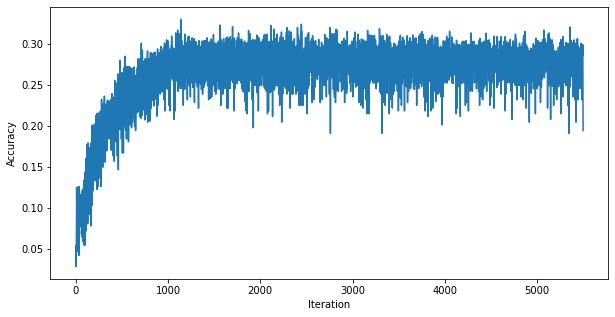

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

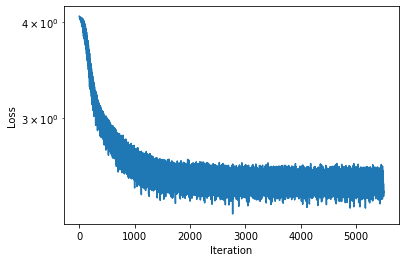

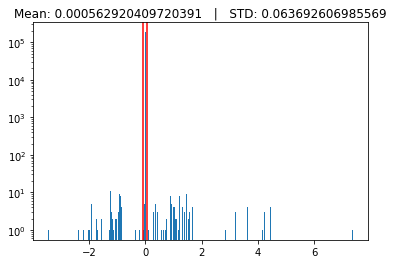

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 8.711206896551724


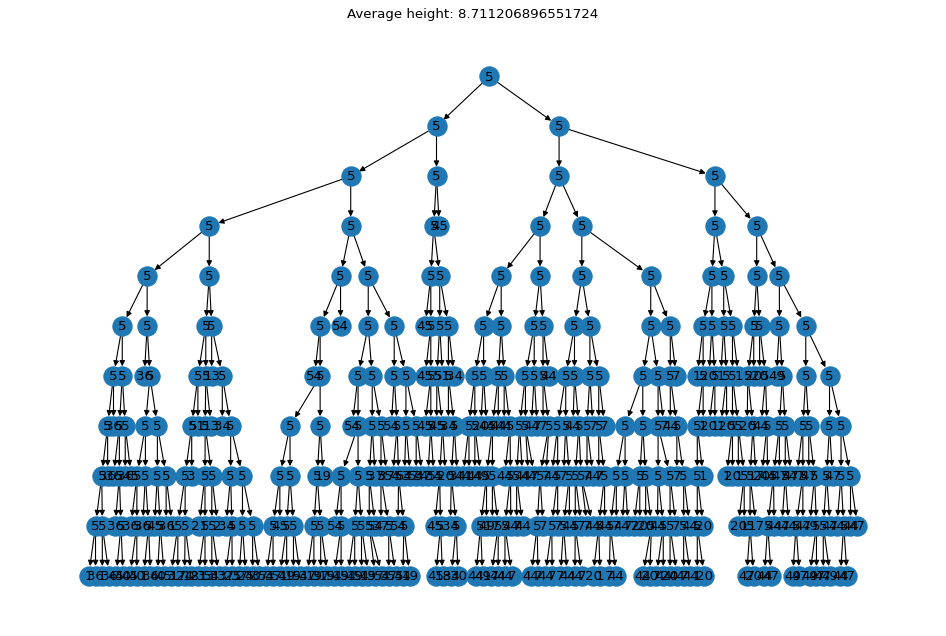

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [31]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 232


In [32]:
method = 'MLE'

In [33]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [34]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
424
============== Pattern 5 ==============
251
============== Pattern 6 ==============
============== Pattern 7 ==============
68
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
16
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
===========

============== Pattern 211 ==============
============== Pattern 212 ==============
============== Pattern 213 ==============
============== Pattern 214 ==============
============== Pattern 215 ==============
============== Pattern 216 ==============
============== Pattern 217 ==============
============== Pattern 218 ==============
============== Pattern 219 ==============
============== Pattern 220 ==============
============== Pattern 221 ==============
============== Pattern 222 ==============
============== Pattern 223 ==============
============== Pattern 224 ==============
============== Pattern 225 ==============
============== Pattern 226 ==============
============== Pattern 227 ==============
============== Pattern 228 ==============
============== Pattern 229 ==============
============== Pattern 230 ==============
============== Pattern 231 ==============
============== Pattern 232 ==============
Average comprehensibility: 83.96551724137932
std comprehensibility: 13.36744